### Importation des librairies

In [ ]:
# installation rapide des librairies à importer
pip install -r requirements.txt

In [1]:
# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

# Modélisation / Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, balanced_accuracy_score,
    mean_absolute_error, mean_squared_error, r2_score)
from sklearn.tree import plot_tree

# Géolocalisation
from geopy.geocoders import Nominatim

# Autres
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

# Options pandas
pd.set_option('display.max_columns', None)

### Chargement des données

In [2]:
# source : https://data.sncf.com/explore/dataset/regularite-mensuelle-tgv-aqst/information/
df = pd.read_csv("regularite-mensuelle-tgv-aqst.csv", sep=';')
print("Dimensions:", df.shape)
df.info()
df.describe()

# Affichage des noms de colonnes et types de données
print("\nColonnes :")
for col in df.columns : print(col)
print("\nTypes de données :\n", df.dtypes)

# Données manquantes
missing = df.isnull().mean().sort_values(ascending=False)
print("\nColonnes avec valeurs manquantes :\n", missing[missing > 0])

# Nombre de gares uniques
print("Nombre de gares d'arrivée :", df["Gare d'arrivée"].nunique())
print("Nombre de gares de départ :", df["Gare de départ"].nunique())

Dimensions: (10324, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 26 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   Date                                                                                         10324 non-null  object 
 1   Service                                                                                      10324 non-null  object 
 2   Gare de départ                                                                               10324 non-null  object 
 3   Gare d'arrivée                                                                               10324 non-null  object 
 4   Durée moyenne du trajet                                                                      10324 non-null  int64  
 5   Nombre d

In [3]:
df.describe()

Durée moyenne du trajet  Nombre de circulations prévues  \
count             10324.000000                    10324.000000   
mean                170.279252                      268.205734   
std                  87.628879                      180.983787   
min                   0.000000                        0.000000   
25%                  99.750000                      148.000000   
50%                 163.000000                      228.000000   
75%                 222.000000                      353.000000   
max                 786.000000                     1100.000000   

       Nombre de trains annulés  Commentaire annulations  \
count               10324.00000                      0.0   
mean                    9.53981                      NaN   
std                    24.00411                      NaN   
min                     0.00000                      NaN   
25%                     0.00000                      NaN   
50%                     2.00000                      NaN   
75%                     8.00000                      NaN   
max                   297.00000                      NaN   

       Nombre de trains en retard au départ  \
count                          10324.000000   
mean                              87.250678   
std                               89.407302   
min                                0.000000   
25%                               22.000000   
50%                               53.000000   
75%                              128.000000   
max                              596.000000   

       Retard moyen des trains en retard au départ  \
count                                 10324.000000   
mean                                     11.839603   
std                                      11.777413   
min                                       0.000000   
25%                                       5.821379   
50%                                       9.898992   
75%                                      15.070522   
max                                     316.188095   

       Retard moyen de tous les trains au départ  \
count                               10324.000000   
mean                                    3.056891   
std                                     4.963690   
min                                  -229.269444   
25%                                     1.174807   
50%                                     2.269550   
75%                                     3.904698   
max                                    84.516667   

       Commentaire retards au départ  Nombre de trains en retard à l'arrivée  \
count                            0.0                            10324.000000   
mean                             NaN                               36.544072   
std                              NaN                               30.746272   
min                              NaN                                0.000000   
25%                              NaN                               15.000000   
50%                              NaN                               29.000000   
75%                              NaN                               50.000000   
max                              NaN                              376.000000   

       Retard moyen des trains en retard à l'arrivée  \
count                                   10324.000000   
mean                                       34.520114   
std                                        15.630608   
min                                       -40.109259   
25%                                        25.227885   
50%                                        32.878781   
75%                                        41.684413   
max                                       299.600000   

       Retard moyen de tous les trains à l'arrivée  \
count                                 10324.000000   
mean                                      5.850159   
std                                       7.283000   
min                                    -472.63888

### Nettoyage des données

In [4]:
# Standardisation des noms de colonnes
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("'", "").str.lower()

# Suppression des colonnes inutiles
df = df.drop(columns = ["commentaire_annulations", "commentaire_retards_au_départ", "commentaire_retards_à_larrivée"])

# Renommage clair des colonnes 
new_columns = [
    'date', 'service', 'gare_depart', 'gare_arrivee',
    'duree_moyenne', 'nb_train_prevu', 'nb_annulation',
    'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee',
    'retard_moyen_tous_trains_arrivee',
    'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
    'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
    'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
    'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
    'prct_cause_prise_en_charge_voyageurs'
]

rename_dict = dict(zip(df.columns, new_columns))

df = df.rename(columns=rename_dict)

# Conversion de la date
df['date'] = pd.to_datetime(df['date'], format="%Y-%m")

### Features en plus

In [5]:
# Pourcentage de trains en retard de plus de 15 minutes
df['pct_retard_15min'] = df['nb_train_retard_sup_15'] / df['nb_train_prevu']

# Lignes complètes de train
df['ligne'] = df['gare_depart']+ ' - ' + df['gare_arrivee']

### Analyse globale des causes

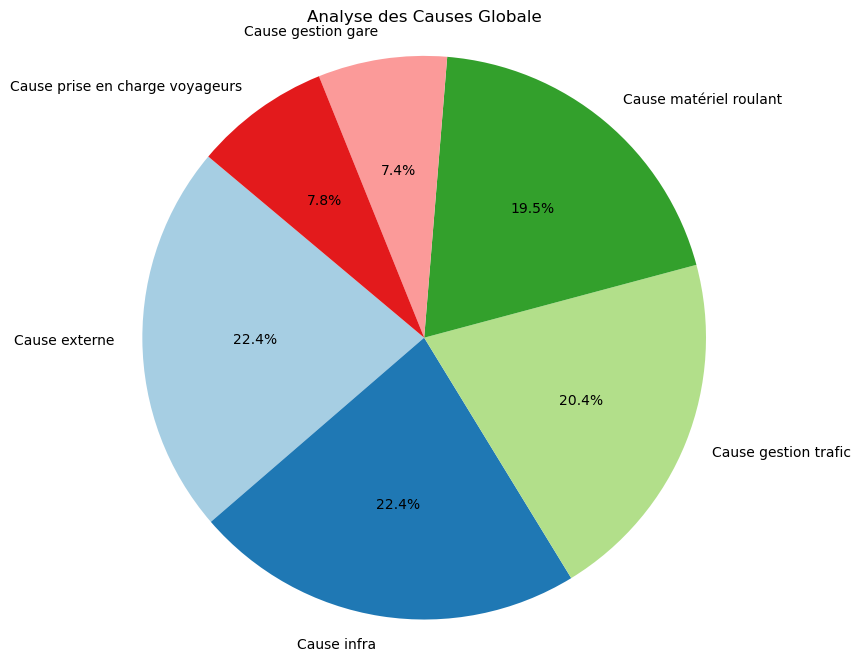

In [6]:
# Moyennes des retards selon la gare de départ
df.groupby('gare_depart')['retard_moyen_tous_trains_arrivee'].mean().sort_values(ascending=False).head(10)

# Moyenne globale des causes
causes = ["Cause externe", "Cause infra", "Cause gestion trafic", "Cause matériel roulant", "Cause gestion gare", "Cause prise en charge voyageurs"]
prct_causes = df[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]].mean()

# Pie chart global
plt.figure(figsize=(8, 8))
plt.pie(prct_causes, labels=causes, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(causes))))
plt.title("Analyse des Causes Globale")
plt.axis('equal')  # pie chart soit bien un cercle
plt.show()

### Analyse des causes par ligne

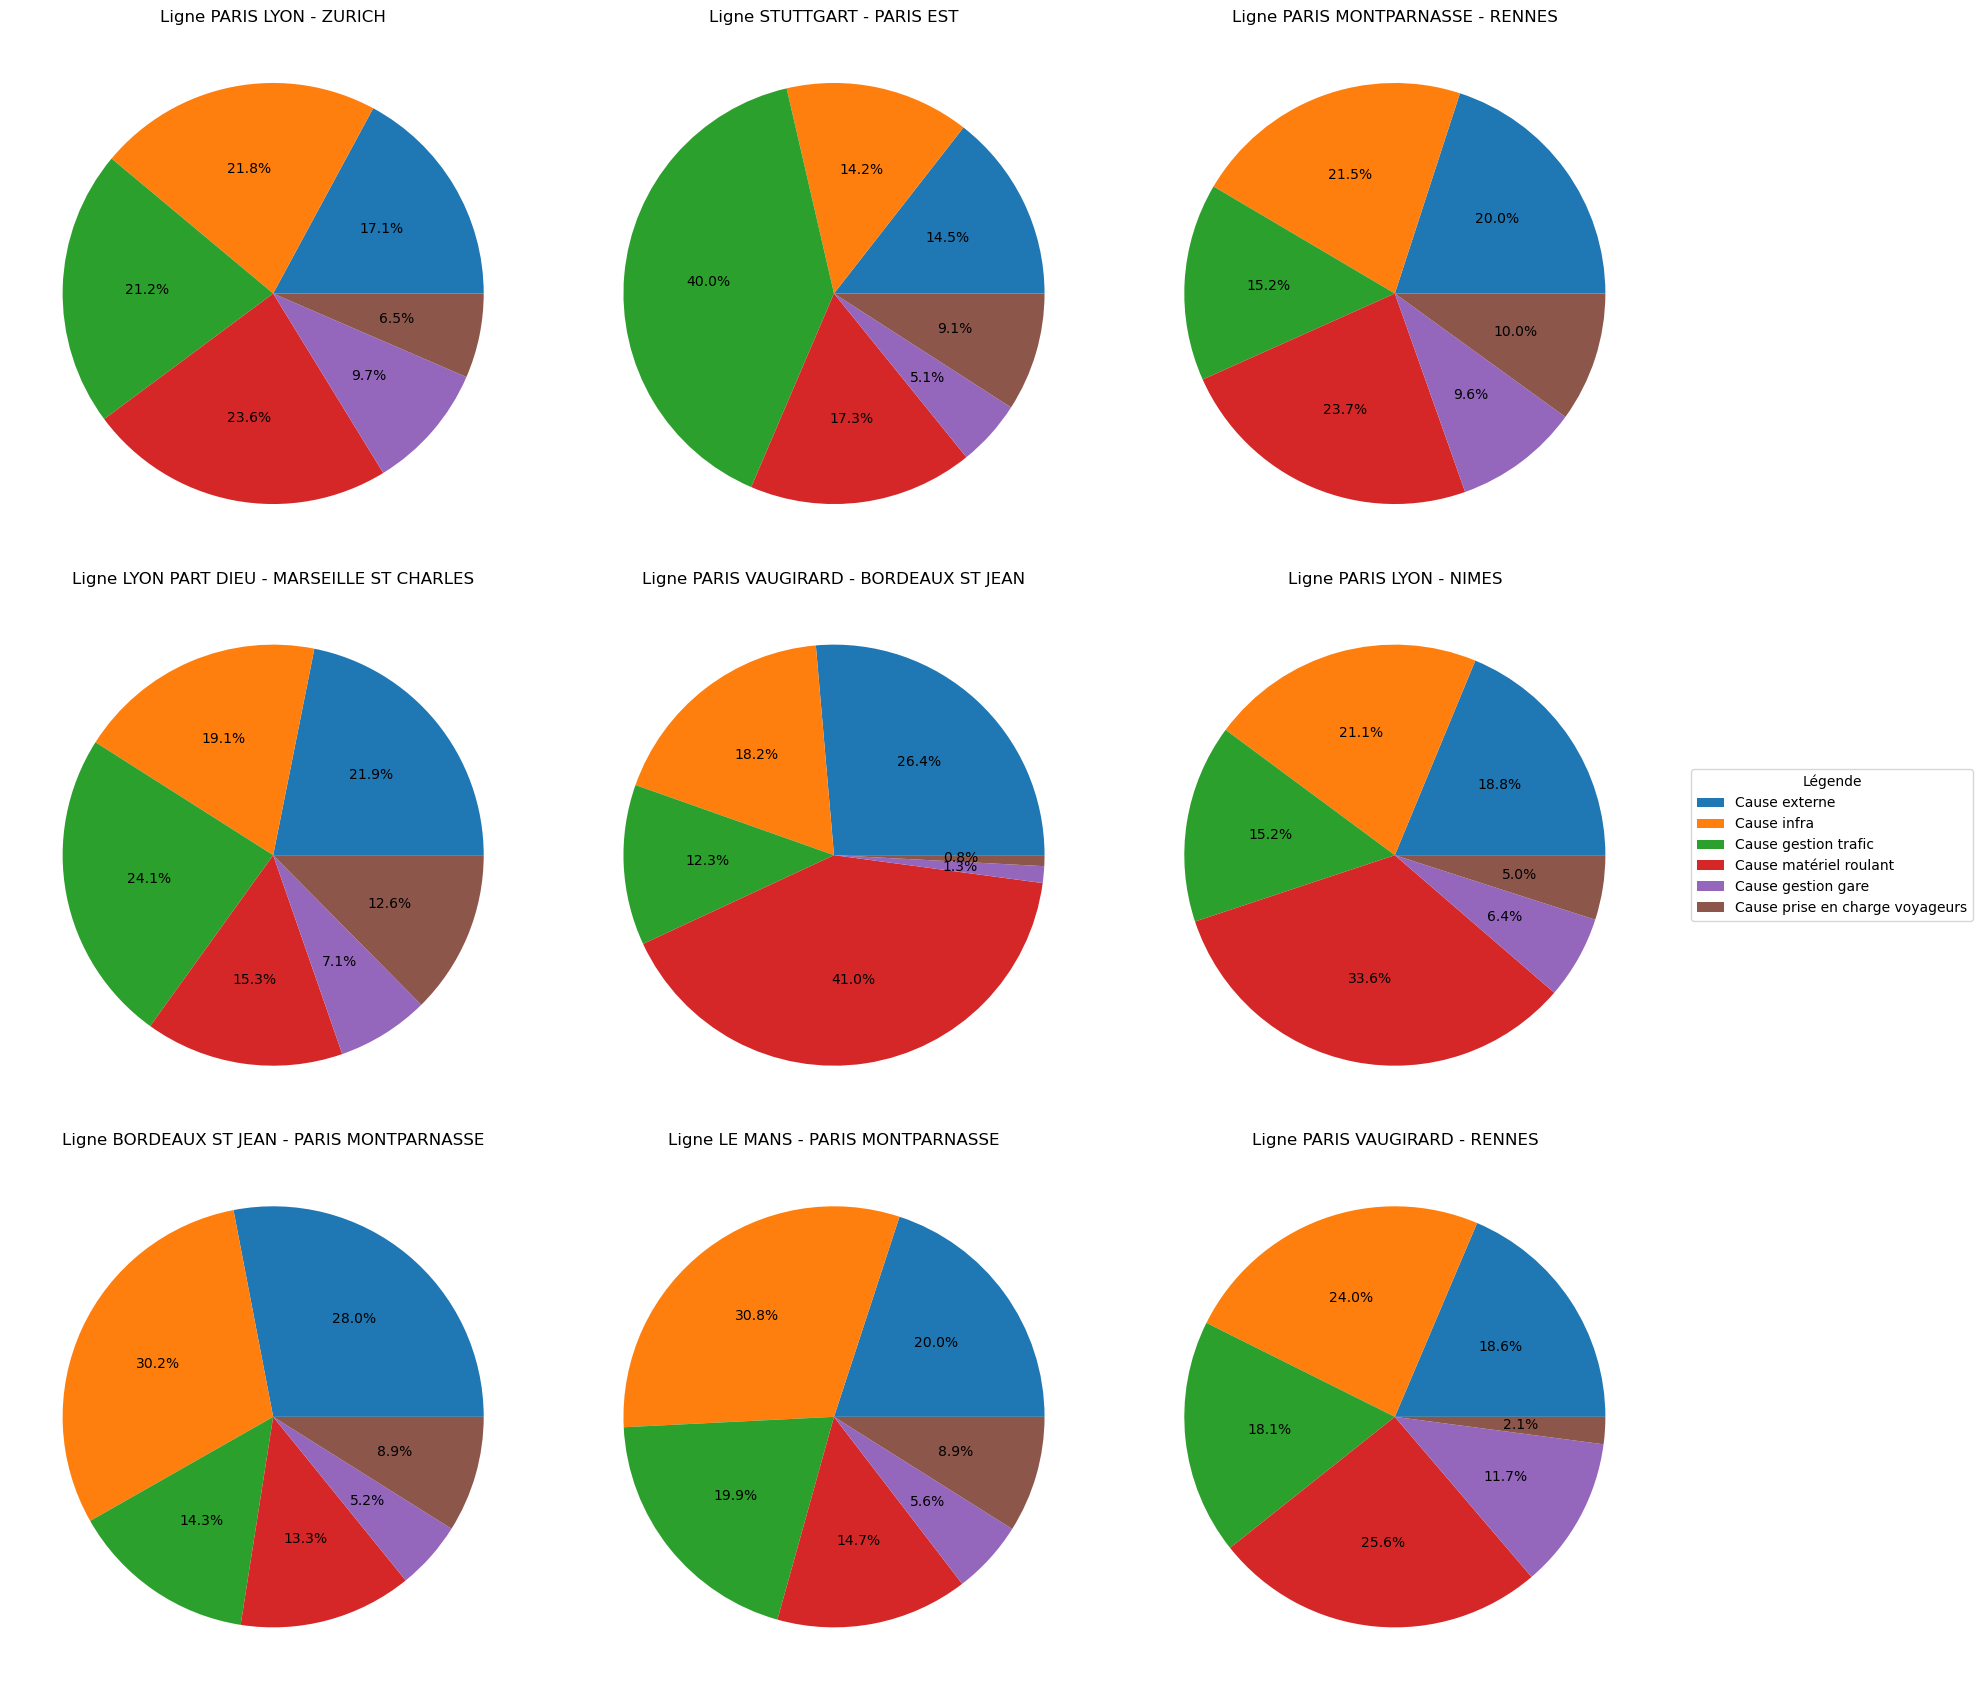

In [7]:
df_groupby_ligne = df.groupby("ligne").agg(
    Cause_externe = ("prct_cause_externe",'mean'),
    Cause_infra = ("prct_cause_infra",'mean'),
    Cause_gestion_trafic = ("prct_cause_gestion_trafic",'mean'),
    Cause_materiel_roulant = ("prct_cause_materiel_roulant",'mean'),
    Cause_gestion_gare = ("prct_cause_gestion_gare",'mean'),
    Cause_prise_en_charge_voyageurs = ("prct_cause_prise_en_charge_voyageurs",'mean')
)

df_groupby_ligne.describe()

# Sélection de 9 lignes aléatoires
selected_lines = [df_groupby_ligne.sample(1).reset_index() for _ in range(9)]

# Création d'une grille de sous-graphiques de 3 lignes par 3 colonnes
fig, axes = plt.subplots(3, 3, figsize=(17, 17))

# Création des graphiques pie pour chaque ligne sélectionnée
for i, selected_line in enumerate(selected_lines):
    # Réorganisez les données pour les rendre adaptées à un pie chart
    ligne_name = selected_line.ligne.values[0]
    selected_line = selected_line.drop(columns=['ligne']).T
    selected_line.columns = ['Pourcentage']

    # Créez un graphe pie
    ax = axes[i // 3, i % 3]
    wedges, texts, autotexts = ax.pie(selected_line['Pourcentage'], labels=[''] * len(selected_line.index), autopct='%1.1f%%')
    ax.set_title(f"Ligne {ligne_name}")

# Ajustement l'espacement entre les graphiques
plt.tight_layout()
fig.legend(wedges, labels=causes, loc="center left", bbox_to_anchor=(1, 0.5), title="Légende")
plt.show()


### Evolution des causes par mois

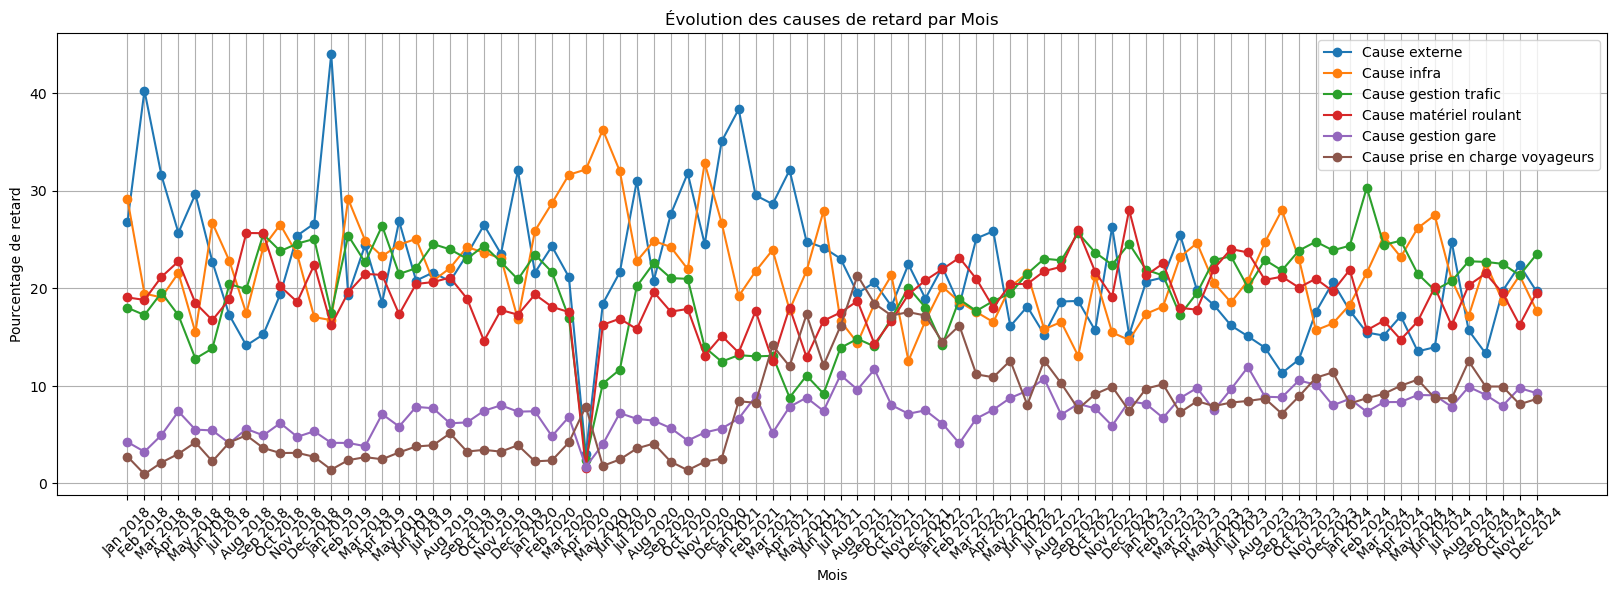

In [8]:
df_month = df.groupby("date")[["prct_cause_externe", "prct_cause_infra", "prct_cause_gestion_trafic", "prct_cause_materiel_roulant", "prct_cause_gestion_gare", "prct_cause_prise_en_charge_voyageurs"]].mean().reset_index()
df_month.describe()

df_month['date'] = pd.to_datetime(df_month['date'])
df_month['date'] = df_month['date'].dt.to_period('M')
df_month = df_month.set_index("date")
df_month.index = df_month.index.strftime('%b %Y')

plt.figure(figsize=(20, 6))
for col, label in zip(df_month.columns, causes):
    plt.plot(df_month.index, df_month[col], marker='o', label=label)

plt.title("Évolution des causes de retard par Mois")
plt.xlabel("Mois")
plt.ylabel("Pourcentage de retard")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Focus sur une ligne spécifique

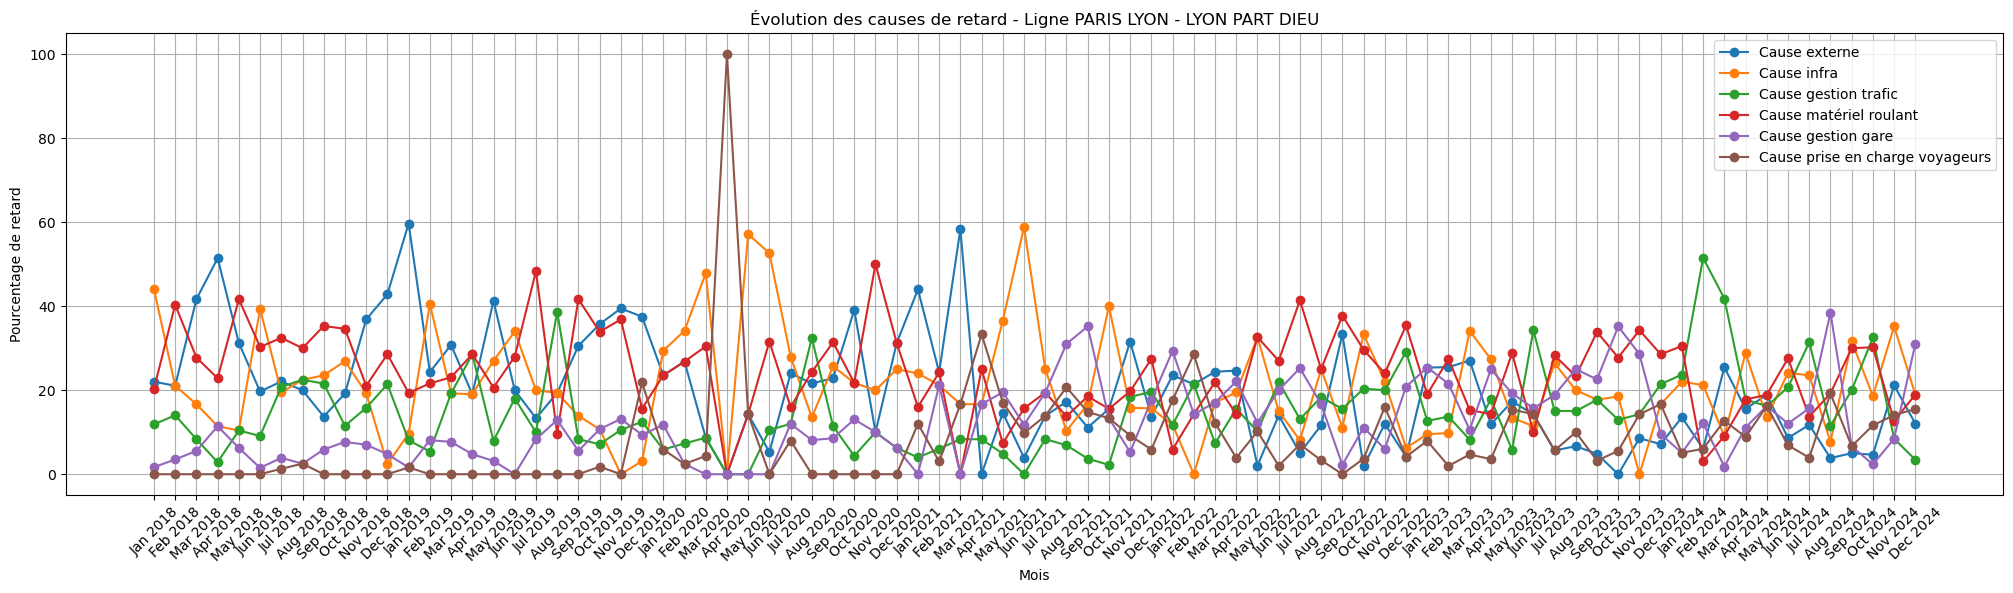

In [9]:
ligne_focus = "PARIS LYON - LYON PART DIEU"
df_ligne = df[df.ligne == ligne_focus].groupby("date")[df_month.columns].mean().reset_index()

df_ligne['date'] = pd.to_datetime(df_ligne['date']).dt.to_period('M')
df_ligne = df_ligne.set_index("date")
df_ligne.index = df_ligne.index.strftime('%b %Y')

plt.figure(figsize=(25, 6))
for col, label in zip(df_ligne.columns, causes):
    plt.plot(df_ligne.index, df_ligne[col], marker='o', label=label)

plt.title(f"Évolution des causes de retard - Ligne {ligne_focus}")
plt.xlabel("Mois")
plt.ylabel("Pourcentage de retard")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Evolution des retards par mois: départ et arrivée

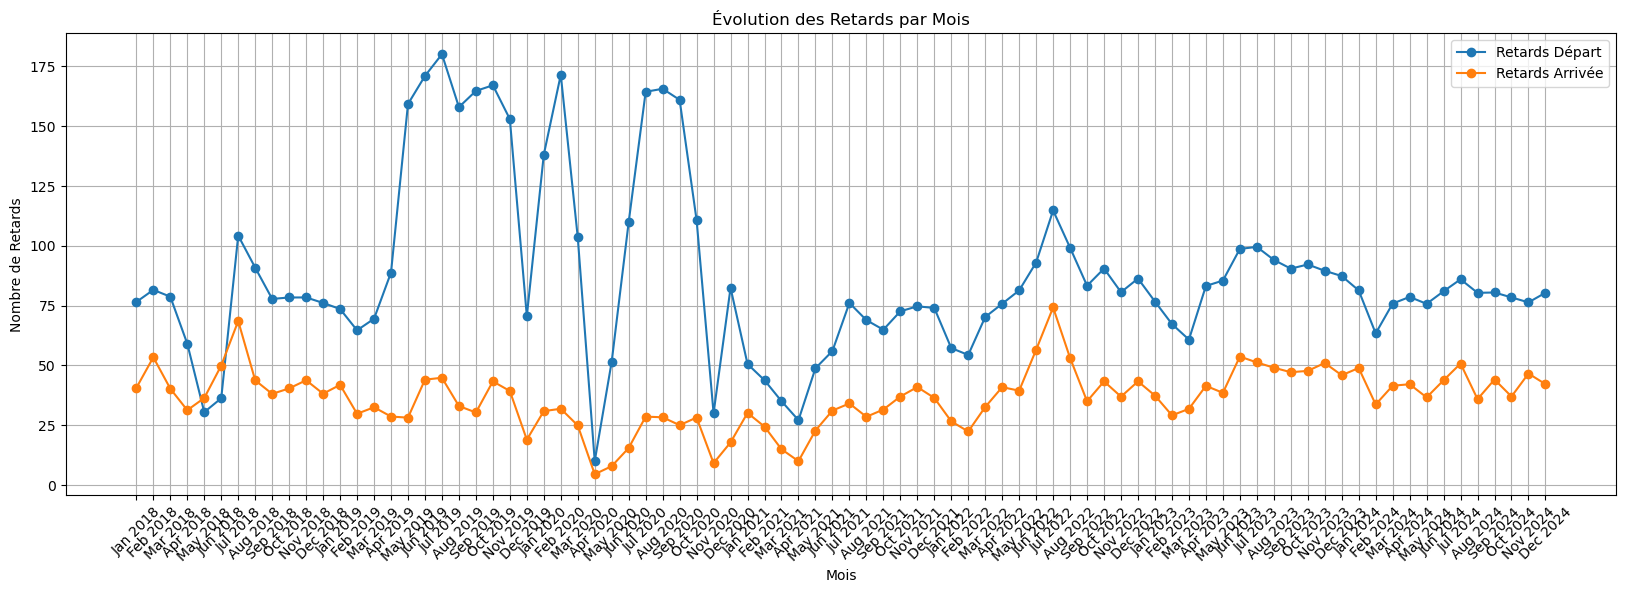

In [10]:
retards_mois = df.groupby("date")[["nb_train_depart_retard", "nb_train_retard_arrivee"]].mean().reset_index()
retards_mois['date'] = pd.to_datetime(retards_mois['date']).dt.to_period('M')
retards_mois = retards_mois.set_index("date")
retards_mois.index = retards_mois.index.strftime('%b %Y')

plt.figure(figsize=(20, 6))
plt.plot(retards_mois.index, retards_mois["nb_train_depart_retard"], marker='o', label='Retards Départ')
plt.plot(retards_mois.index, retards_mois["nb_train_retard_arrivee"], marker='o', label='Retards Arrivée')
plt.title("Évolution des Retards par Mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de Retards")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Comparaison de deux lignes

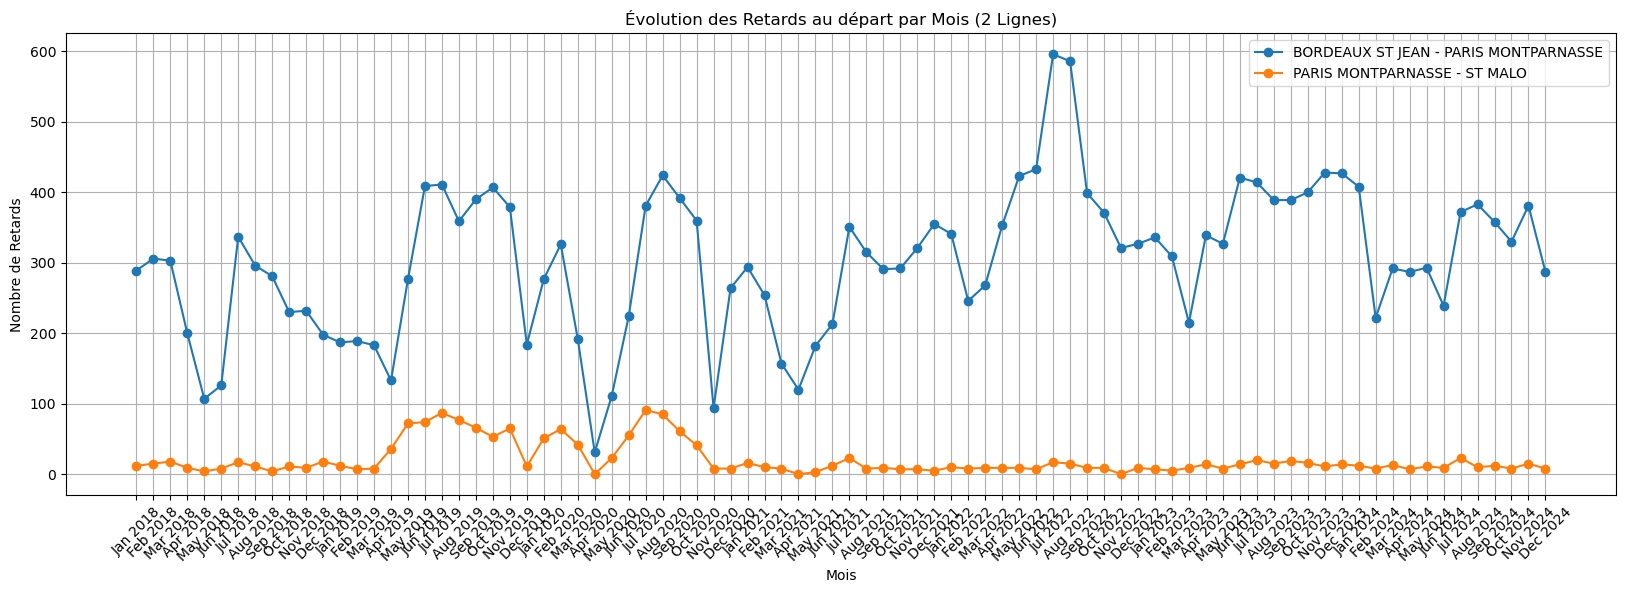

In [11]:
lignes = ["BORDEAUX ST JEAN - PARIS MONTPARNASSE", "PARIS MONTPARNASSE - ST MALO"]

dfs = []

for ligne in lignes:
    temp = df[df.ligne == ligne][['date', 'nb_train_depart_retard']]
    temp['date'] = pd.to_datetime(temp['date']).dt.to_period('M')
    temp = temp.set_index("date")
    temp.index = temp.index.strftime('%b %Y')
    dfs.append(temp)

plt.figure(figsize=(20, 6))
plt.plot(dfs[0].index, dfs[0]["nb_train_depart_retard"], marker='o', label=lignes[0])
plt.plot(dfs[1].index, dfs[1]["nb_train_depart_retard"], marker='o', label=lignes[1])
plt.title("Évolution des Retards au départ par Mois (2 Lignes)")
plt.xlabel("Mois")
plt.ylabel("Nombre de Retards")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Matrice de corrélation

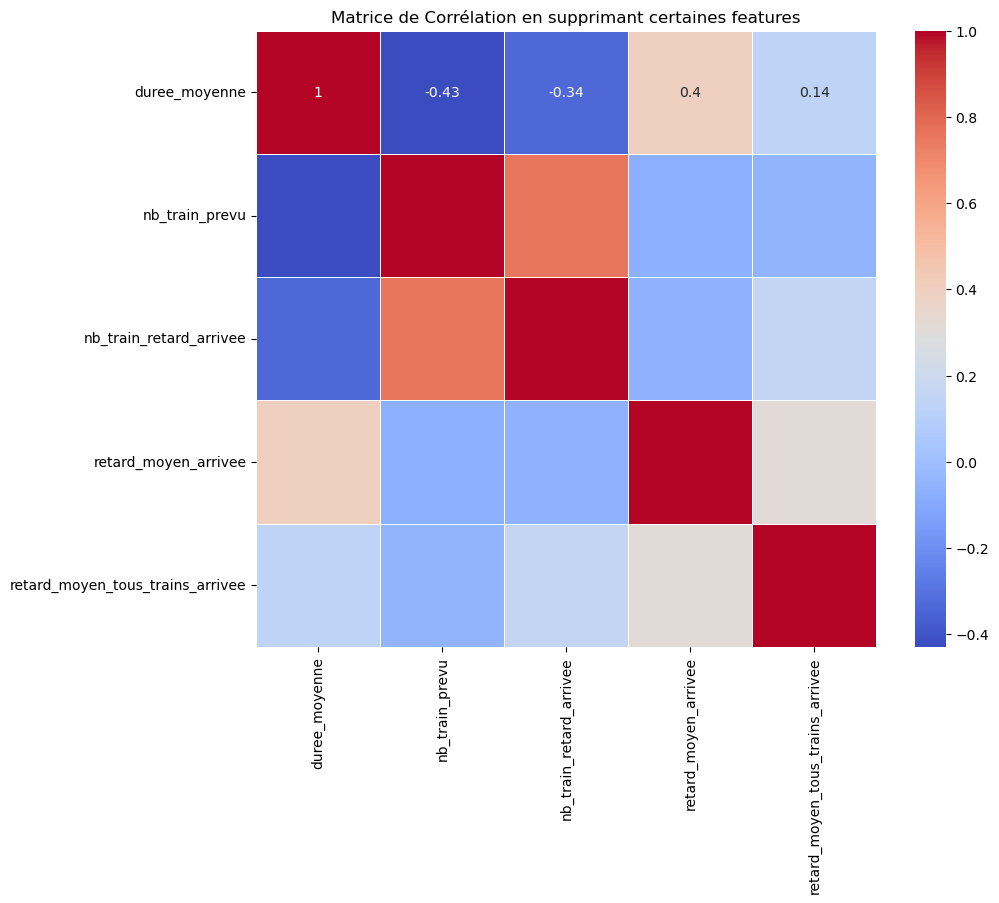

In [12]:
correlation_matrix = df[["duree_moyenne", "nb_train_prevu", "nb_train_retard_arrivee", "retard_moyen_arrivee", "retard_moyen_tous_trains_arrivee"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de Corrélation en supprimant certaines features")
plt.show()

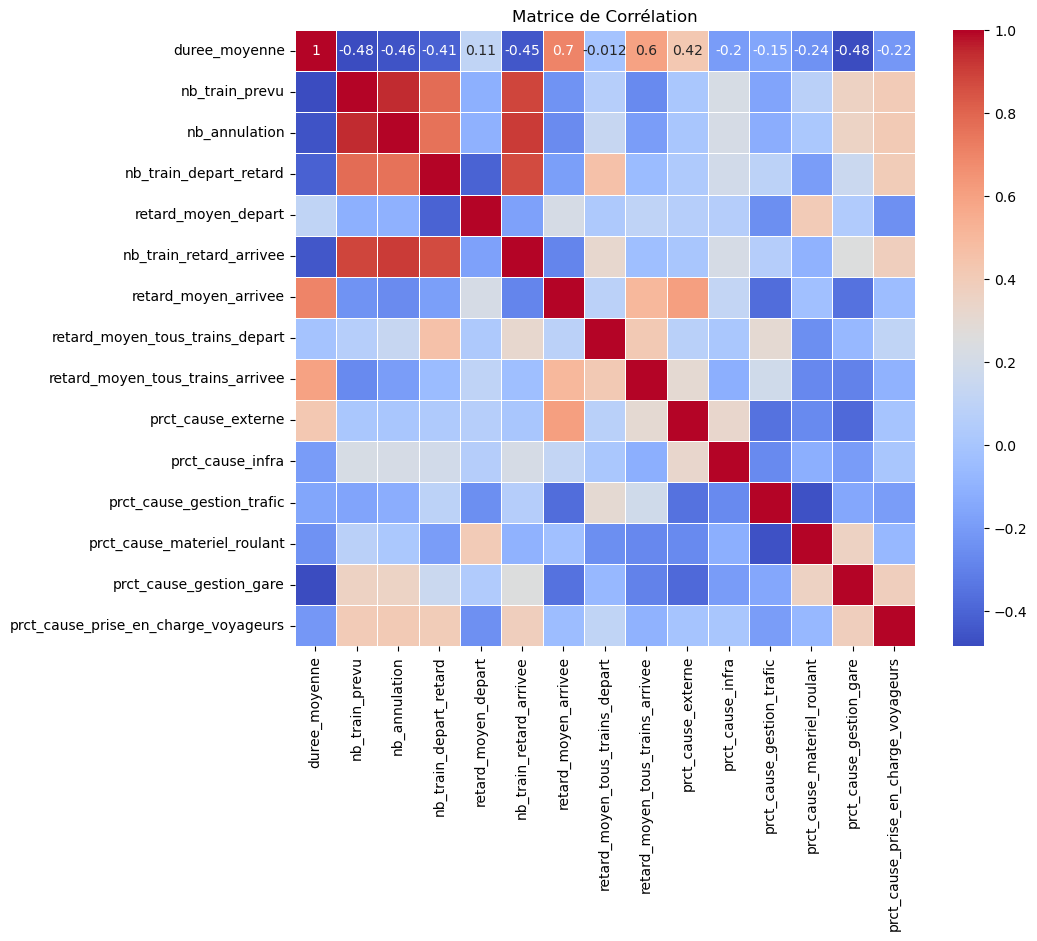

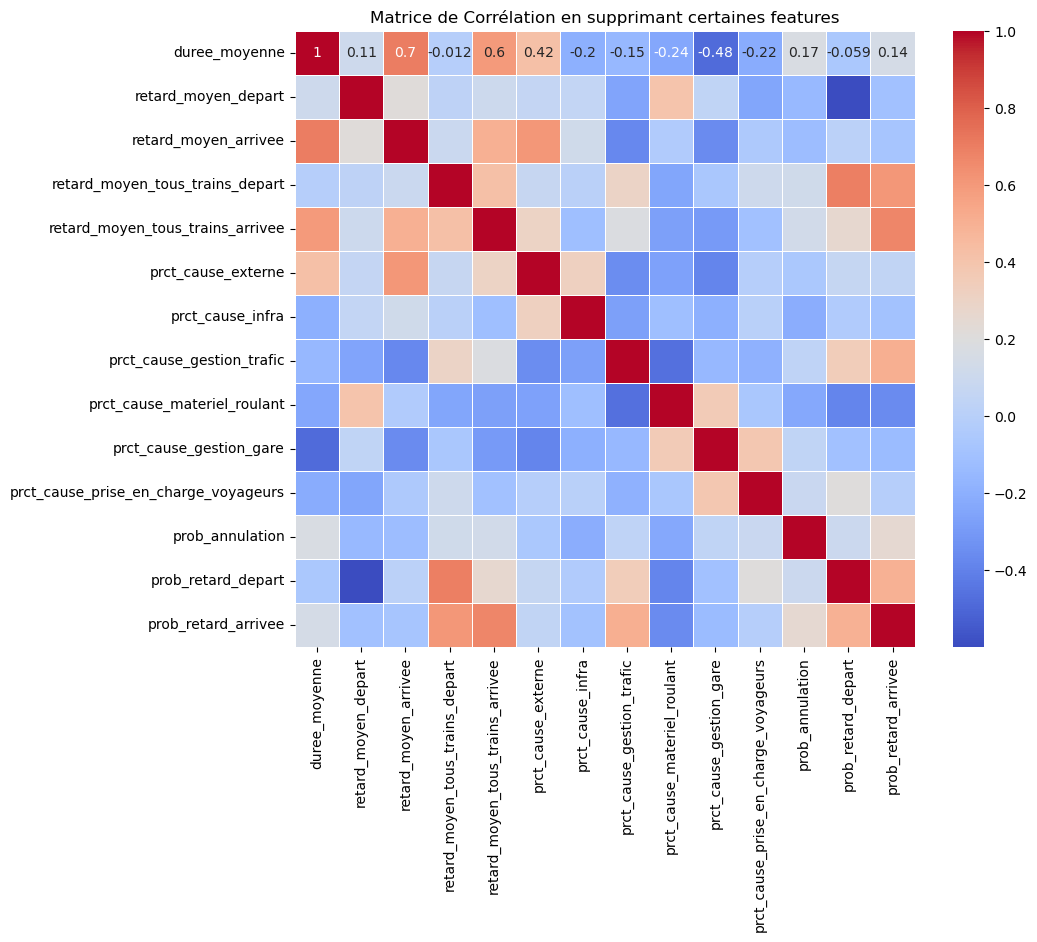

In [13]:
## Matrice 1: matrice de corrélation brute, complète par ligne TGV
df_groupeby_ligne_bis = df.groupby("ligne").agg(
    duree_moyenne = ("duree_moyenne", "mean"),
    nb_train_prevu = ("nb_train_prevu", "mean"),
    nb_annulation = ("nb_annulation", "mean"),
    nb_train_depart_retard = ("nb_train_depart_retard", "mean"),
    retard_moyen_depart = ("retard_moyen_depart", "mean"),
    nb_train_retard_arrivee = ("nb_train_retard_arrivee", "mean"),
    retard_moyen_arrivee = ("retard_moyen_arrivee", "mean"),
    retard_moyen_tous_trains_depart = ("retard_moyen_tous_trains_depart", "mean"),
    retard_moyen_tous_trains_arrivee = ("retard_moyen_tous_trains_arrivee", "mean"),
    prct_cause_externe = ("prct_cause_externe", "mean"),
    prct_cause_infra = ("prct_cause_infra", "mean"),
    prct_cause_gestion_trafic = ("prct_cause_gestion_trafic", "mean"),
    prct_cause_materiel_roulant = ("prct_cause_materiel_roulant", "mean"),
    prct_cause_gestion_gare = ("prct_cause_gestion_gare", "mean"),
    prct_cause_prise_en_charge_voyageurs = ("prct_cause_prise_en_charge_voyageurs", "mean"))

df_corr_matrix = df_groupeby_ligne_bis.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

## Matrice 2: normalisée, supprime l’effet taille des lignes
# ajout de proba
df_groupeby_ligne_bis["prob_annulation"] = df_groupeby_ligne_bis["nb_annulation"] / df_groupeby_ligne_bis["nb_train_prevu"]
df_groupeby_ligne_bis["prob_retard_depart"] = df_groupeby_ligne_bis["nb_train_depart_retard"] / df_groupeby_ligne_bis["nb_train_prevu"]
df_groupeby_ligne_bis["prob_retard_arrivee"] = df_groupeby_ligne_bis["nb_train_retard_arrivee"] / df_groupeby_ligne_bis["nb_train_prevu"]

df_groupeby_ligne_bis.drop(columns=["nb_annulation", "nb_train_depart_retard", "nb_train_retard_arrivee","nb_train_prevu"], inplace=True)

df_corr_matrix = df_groupeby_ligne_bis.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de Corrélation en supprimant certaines features")
plt.show()

### Analyse de l'influence du Covid

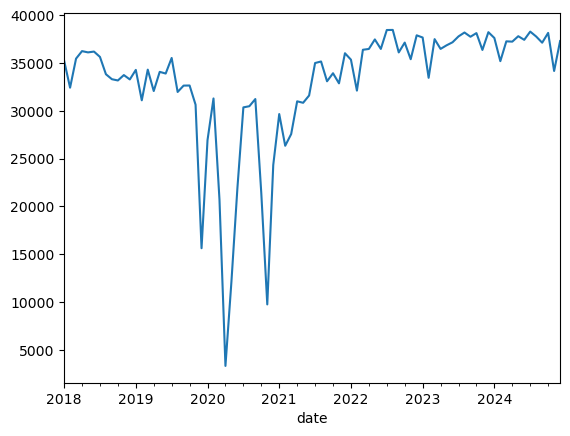

In [14]:
# Affiche les dates où aucun train n'était prévu (ex. confinement)
df.loc[((df.nb_train_prevu == 0))].date.unique()

# Volume total de trains prévus par date (permet de repérer la chute durant la pandémie)
df.groupby("date")["nb_train_prevu"].sum().plot();

### Géolocalisation des gares (pour cartographie)

In [15]:
gare_to_pays = {"GENEVE":"Suisse", "ZURICH":"Suisse", "ITALIE":"Italie", "LAUSANNE":"Suisse", "BARCELONA":"Espagne", "MADRID":"Espagne", "STUTTGART":"Allemagne", "FRANCFORT":"Allemagne"}

geolocator = Nominatim(user_agent="val", timeout=10)

def get_coordinates(station_names):
    station_coords = {}
    for station_name in station_names:
        if station_name in station_coords.keys():
            break
        pays = gare_to_pays.get(station_name, "France")
        location_variable = geolocator.geocode(f"{station_name}, {pays}", limit=1, exactly_one=False)
        #print(location_variable)
        for info in location_variable:
            lat = info.raw["lat"]
            lon = info.raw["lon"]
            station_coords[station_name] = (lat, lon)
    return station_coords

# Liste des gares uniques
station_names = sorted(list(set(list(df.gare_depart.unique()) + list(df.gare_arrivee.unique()))))
station_coords = get_coordinates(station_names)

# Ajout des colonnes de géolocalisation
for station_type in ["depart", "arrivee"]:
    df[f"geo_infos_{station_type}"] = df[f"gare_{station_type}"].apply(lambda x:station_coords[x])

### Visualisation sur carte avec Folium

In [16]:
colors = ["green", "orange", "red"]

for station_type in ["depart", "arrivee"]:
    sncf_map = folium.Map(location=[47,2], zoom_start=5, tiles="cartodb positron")
    df2_train_map = pd.DataFrame(df.groupby([f"gare_{station_type}", "geo_infos_depart", "geo_infos_arrivee"])["retard_moyen_tous_trains_arrivee"].mean()).reset_index(level=[0,1,2]).copy(deep=True)
    max_mean_delay = max(df2_train_map.retard_moyen_tous_trains_arrivee)

    for idx, row in df2_train_map.iterrows():
        line_coords = []
        geo_col_name = f"geo_infos_{station_type}"
        station_col_name = f"gare_{station_type}"
        lat, lon = row[geo_col_name]
        line_coords.append((lat, lon))
        station = row[station_col_name]
        delay = row["retard_moyen_tous_trains_arrivee"]
        if delay <= 0:
            color = colors[0]
        else: 
            color = colors[min(len(colors)-1, int(delay*(len(colors))/max_mean_delay))]
            # On normalise le retard par rapport au maximum observé
        folium.Marker(location=[lat,lon], popup = station, icon=folium.Icon(color=color)).add_to(sncf_map)
        
    titre_français = "départ" if station_type == "depart" else "d'arrivée"
    title_html = f"""<h3 align="center" style="font-size:20px"><b>Carte des gares {titre_français}</b></h3>"""
    sncf_map.get_root().html.add_child(folium.Element(title_html))
    
    sncf_map.save(f"train_map_{station_type}.html")
    display(sncf_map)

### Analyse temporelle globale

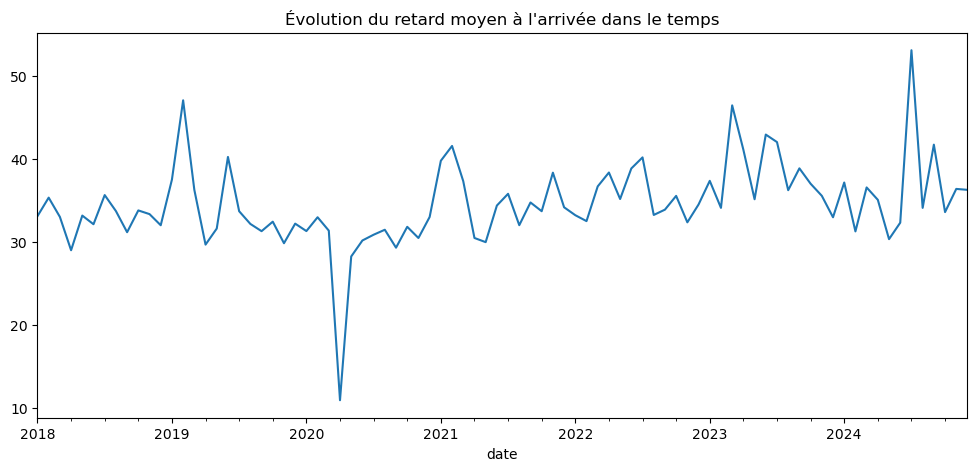

In [17]:
# Retard moyen par jour
df_grouped = df.groupby('date')['retard_moyen_arrivee'].mean()
df_grouped.plot(figsize=(12, 5), title="Évolution du retard moyen à l'arrivée dans le temps");

### Top liaisons les plus en retard

<Axes: title={'center': "Top 10 des liaisons avec le plus de retard moyen à l'arrivée"}, ylabel='gare_depart,gare_arrivee'>

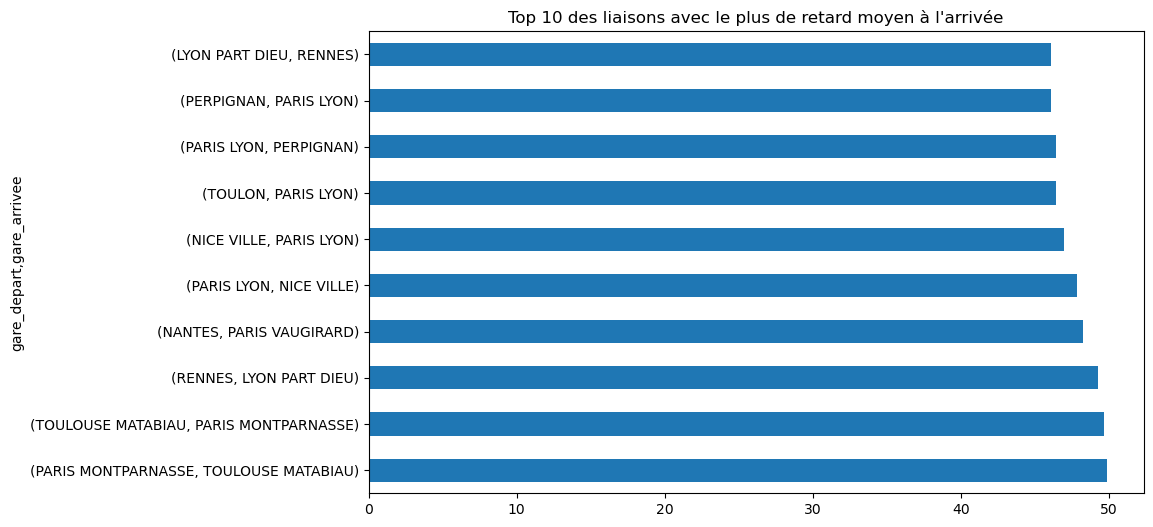

In [18]:
top_liaisons = df.groupby(['gare_depart', 'gare_arrivee'])['retard_moyen_arrivee'].mean().sort_values(ascending=False).head(10)
top_liaisons.plot(kind='barh', title="Top 10 des liaisons avec le plus de retard moyen à l'arrivée", figsize=(10,6))

### Analyse des causes de retard

<Axes: title={'center': 'Causes de retard (moyennes %)'}>

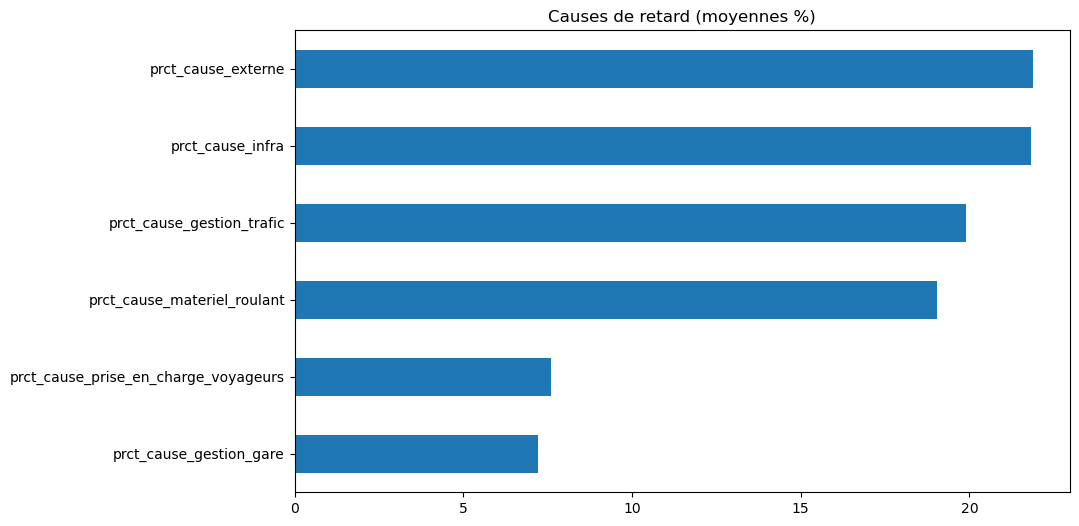

In [19]:
cause_cols = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
              'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
              'prct_cause_prise_en_charge_voyageurs']

df[cause_cols].mean().sort_values().plot(kind='barh', title="Causes de retard (moyennes %)", figsize=(10, 6))

### Gares les plus impactées

<Axes: title={'center': "Top 10 gares avec le plus de trains en retard à l'arrivée"}, xlabel='gare_arrivee'>

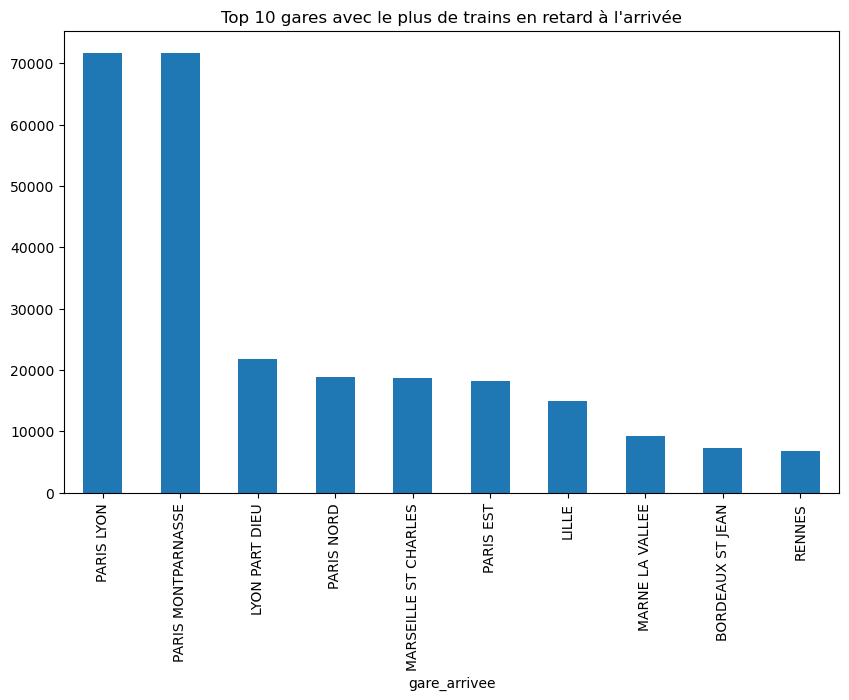

In [20]:
gares_retard = df.groupby('gare_arrivee')['nb_train_retard_arrivee'].sum().sort_values(ascending=False).head(10)
gares_retard.plot(kind='bar', title="Top 10 gares avec le plus de trains en retard à l'arrivée", figsize=(10,6))

### Analyse par service

<Axes: title={'center': 'Nombre d’observations par type de service'}, xlabel='service'>

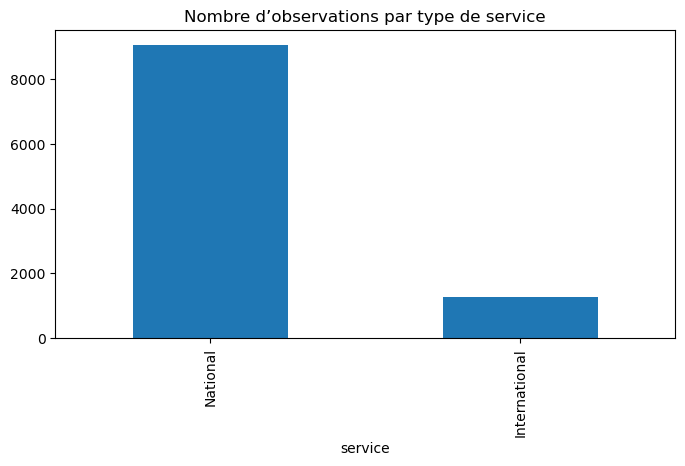

In [21]:
df['service'].value_counts().plot(kind='bar', title='Nombre d’observations par type de service', figsize=(8, 4))

<Axes: title={'center': "Retard moyen à l'arrivée par service"}, ylabel='service'>

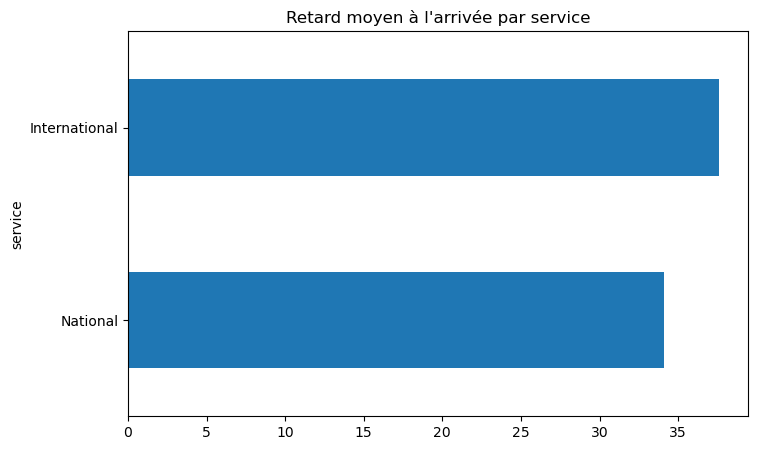

In [22]:
df.groupby('service')['retard_moyen_arrivee'].mean().sort_values().plot(kind='barh', title="Retard moyen à l'arrivée par service", figsize=(8,5))

### Saisonnalité

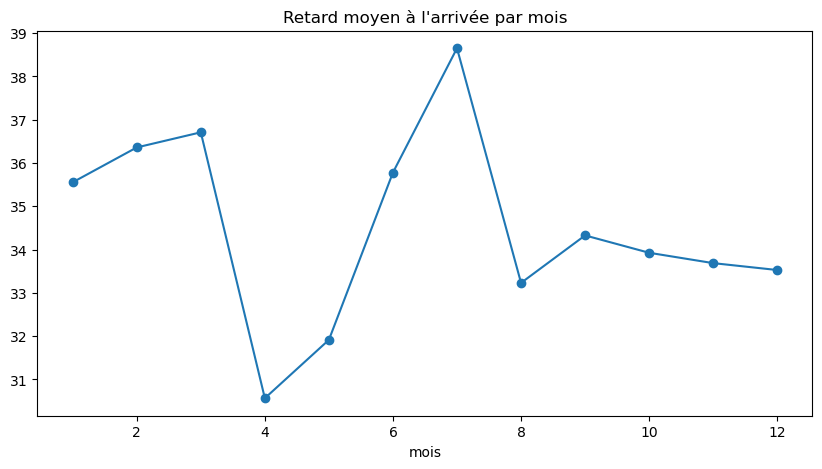

In [23]:
df['mois'] = df['date'].dt.month
df['annee'] = df['date'].dt.year

def get_saison(mois):
    if mois in [12, 1, 2]:
        return 'Hiver'
    elif mois in [3, 4, 5]:
        return 'Printemps'
    elif mois in [6, 7, 8]:
        return 'Été'
    else:
        return 'Automne'

df['saison'] = df['mois'].apply(get_saison)

df.groupby('mois')['retard_moyen_arrivee'].mean().plot(kind='line', marker='o', title="Retard moyen à l'arrivée par mois", figsize=(10,5));

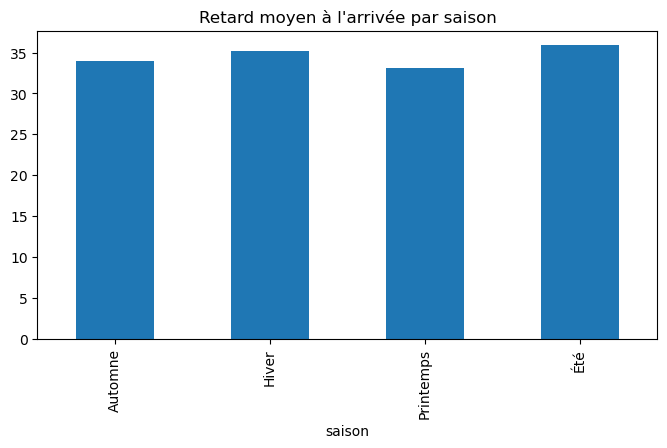

In [24]:
df.groupby('saison')['retard_moyen_arrivee'].mean().plot(kind='bar', title="Retard moyen à l'arrivée par saison", figsize=(8,4));

### Fréquence des gares les plus actives

<Axes: title={'center': 'Gares avec le plus fort retard moyen à l’arrivée'}, ylabel='gare_arrivee'>

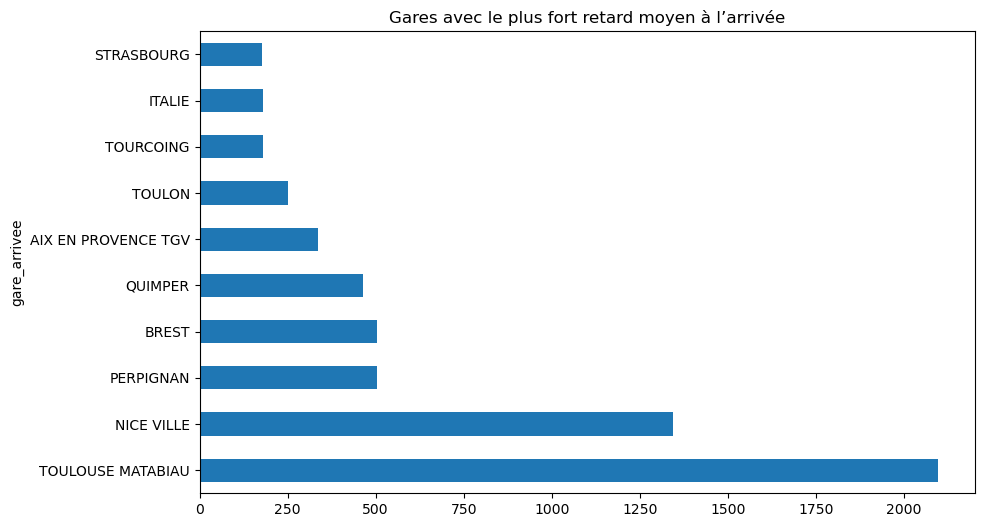

In [25]:
df['gare_depart'].value_counts().head(10).plot(kind='barh', title="Top 10 gares de départ", figsize=(8,5))
df['gare_arrivee'].value_counts().head(10).plot(kind='barh', title="Top 10 gares d'arrivée", figsize=(8,5))
df.groupby('gare_arrivee')['retard_moyen_arrivee'].mean().sort_values(ascending=False).head(10).plot(kind='barh', title="Gares avec le plus fort retard moyen à l’arrivée", figsize=(10,6))

### Pourcentages de retards > 15, 30, 60 minutes

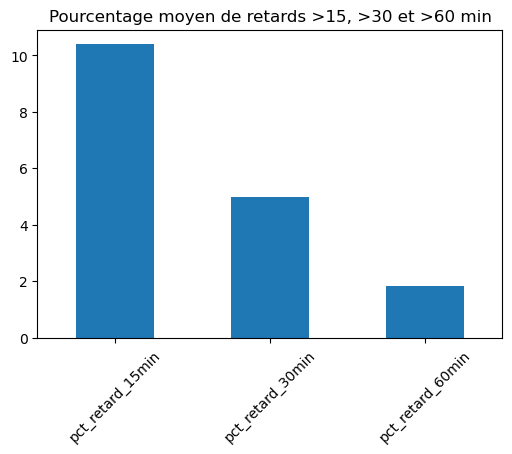

In [26]:
df['pct_retard_15min'] = df['nb_train_retard_sup_15'] / df['nb_train_prevu'] * 100
df['pct_retard_30min'] = df['nb_train_retard_sup_30'] / df['nb_train_prevu'] * 100
df['pct_retard_60min'] = df['nb_train_retard_sup_60'] / df['nb_train_prevu'] * 100

df[['pct_retard_15min', 'pct_retard_30min', 'pct_retard_60min']].describe()

df[['pct_retard_15min', 'pct_retard_30min', 'pct_retard_60min']].mean().plot(kind='bar', title="Pourcentage moyen de retards >15, >30 et >60 min", figsize=(6,4))
plt.xticks(rotation=45);

### Visualisation avancée avec seaborn

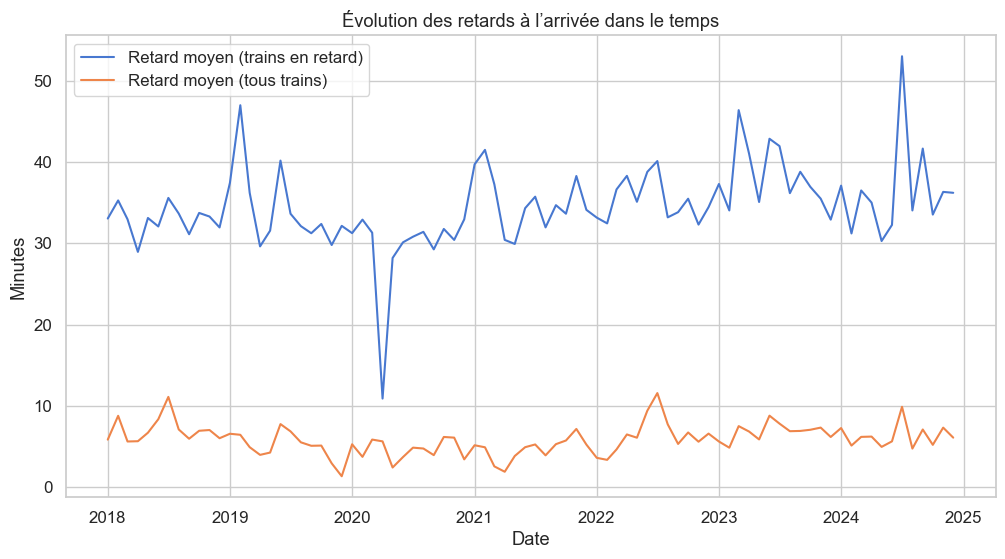

In [27]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)

# Agrégation journalière
df_grouped = df.groupby('date').agg({
    'retard_moyen_arrivee': 'mean',
    'retard_moyen_tous_trains_arrivee': 'mean',
    'nb_train_retard_sup_15': 'sum',
    'nb_train_prevu': 'sum'
}).reset_index()

df_grouped['pct_retard_15min'] = df_grouped['nb_train_retard_sup_15'] / df_grouped['nb_train_prevu'] * 100

sns.lineplot(data=df_grouped, x='date', y='retard_moyen_arrivee', label='Retard moyen (trains en retard)')
sns.lineplot(data=df_grouped, x='date', y='retard_moyen_tous_trains_arrivee', label='Retard moyen (tous trains)')
plt.title("Évolution des retards à l’arrivée dans le temps")
plt.ylabel("Minutes")
plt.xlabel("Date")
plt.legend()
plt.show()

### Retards par saison (boîte à moustaches)

<Axes: xlabel='saison', ylabel='retard_moyen_arrivee'>

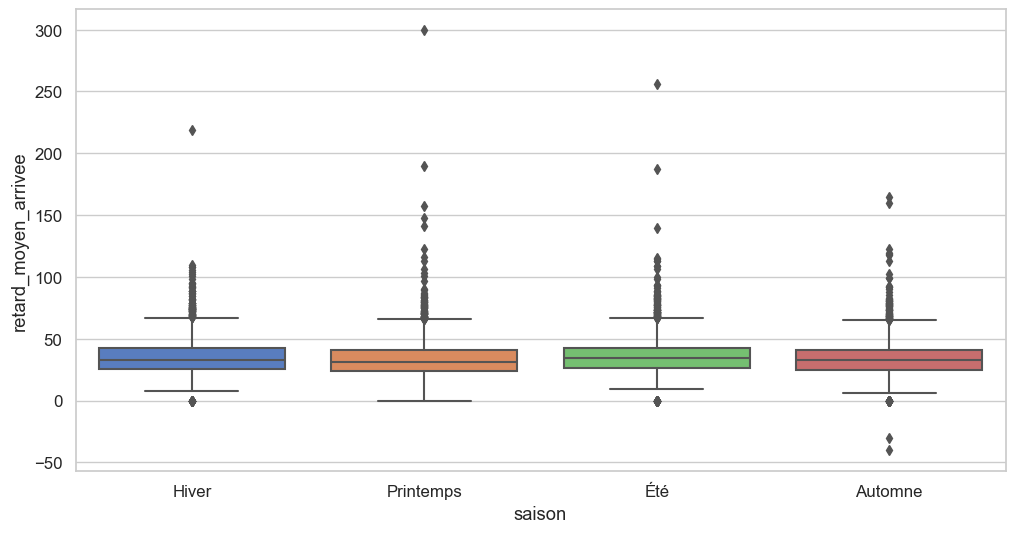

In [28]:
df['saison'] = df['mois'].map({12:'Hiver', 1:'Hiver', 2:'Hiver',
                               3:'Printemps', 4:'Printemps', 5:'Printemps',
                               6:'Été', 7:'Été', 8:'Été',
                               9:'Automne', 10:'Automne', 11:'Automne'})
sns.boxplot(data=df, x='saison', y='retard_moyen_arrivee')

### Top 10 des gares les plus en retard

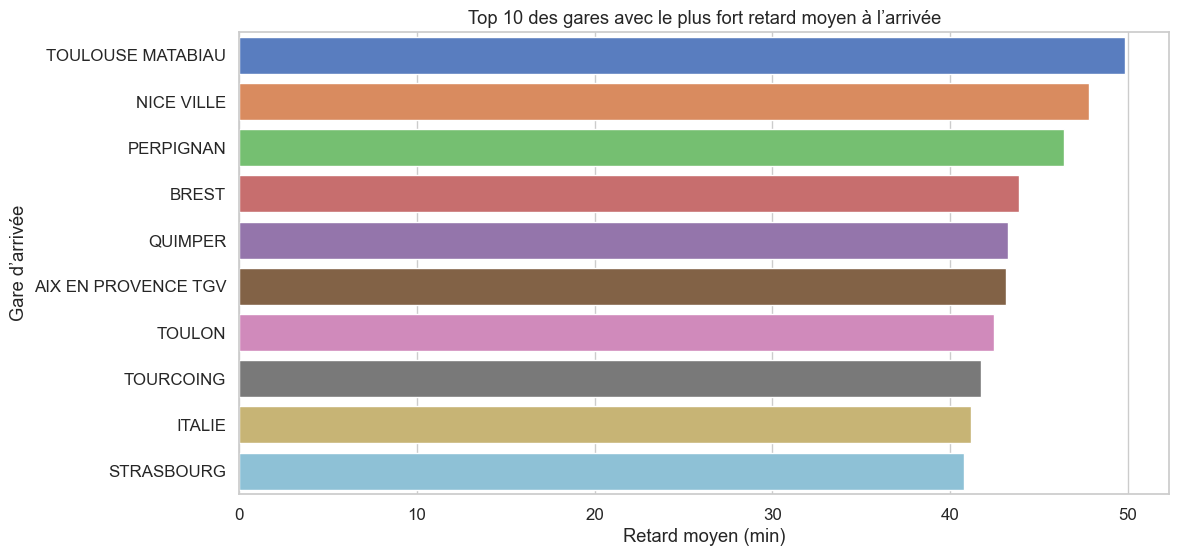

In [29]:
top_gare_retard = df.groupby('gare_arrivee')['retard_moyen_arrivee'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_gare_retard.values, y=top_gare_retard.index)
plt.title("Top 10 des gares avec le plus fort retard moyen à l’arrivée")
plt.xlabel("Retard moyen (min)")
plt.ylabel("Gare d’arrivée")
plt.show()

In [30]:
# Calcul pourcentage retard
df['pct_retard_30min'] = df['nb_train_retard_sup_30'] / df['nb_train_prevu'] * 100
df['pct_retard_60min'] = df['nb_train_retard_sup_60'] / df['nb_train_prevu'] * 100

### Évolution des retards longs dans le temps

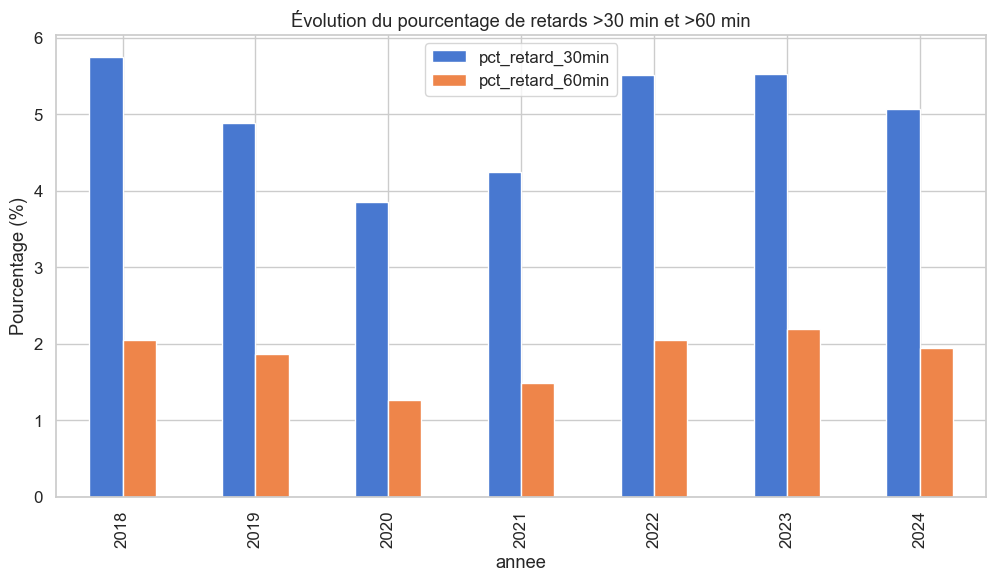

In [31]:
agg = df.groupby('annee')[['pct_retard_30min', 'pct_retard_60min']].mean()
agg.plot(kind='bar')
plt.title("Évolution du pourcentage de retards >30 min et >60 min")
plt.ylabel("Pourcentage (%)")
plt.show()

### Nettoyage final : suppression des outliers

In [32]:
df.describe()["retard_moyen_tous_trains_arrivee"]

count    10324.000000
mean         5.850159
min       -472.638889
25%          3.295463
50%          5.186545
75%          7.861194
max         92.000000
std          7.283000
Name: retard_moyen_tous_trains_arrivee, dtype: float64

In [33]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 3 * IQR  # seuil plus strict
    return df[df[column] <= upper_bound]

df = df[df["retard_moyen_tous_trains_arrivee"] >= 0]
df = remove_outliers_iqr(df, "retard_moyen_tous_trains_arrivee")
df = remove_outliers_iqr(df, "retard_moyen_tous_trains_depart")

### ETAPE 2 : Prétraitement des données

In [34]:
# Sélection des colonnes pertinentes et ajout de premières variables (feature engineering)
columns = df.columns.to_list()
num_cols = ["annee", "mois", "duree_moyenne", "nb_train_prevu", "retard_moyen_tous_trains_arrivee"]
cat_cols = ["service", "gare_depart", "gare_arrivee"]
covid_months = ["2020-03", "2020-04", "2020-05", "2020-11", "2020-12", "2021-04"]

# Copie du dataset initial pour le prétraitement
df1 = df.copy(deep=True)
df1[['annee', 'mois']] = df[['annee', 'mois']]
df1.annee = pd.to_numeric(df1.annee)
df1.mois = pd.to_numeric(df1.mois)
df1["covid"] = df1["date"].apply(lambda x:1 if x in covid_months else 0)
df1.drop(['date'], axis=1, inplace=True)
df1.drop_duplicates(inplace=True)

df1.describe(include="all")

# Fonction pour ajouter les pays à partir des gares
def add_countries(df, gare_to_pays):
    df["pays"] = df.apply(lambda row: gare_to_pays.get(row["gare_depart"], gare_to_pays.get(row["gare_arrivee"], "France")), axis=1)
    return df

df1 = add_countries(df1, gare_to_pays)

### Encode one-hot

In [35]:
# Fonction utilitaire pour encoder des colonnes catégorielles en one-hot
def one_hot_encoder(df, columns, drop_one=False):
    if drop_one:
        liste_colonnes = []
        for col in columns:
            # Crée une liste de noms de colonnes basés sur les valeurs uniques, en excluant le premier élément (index 0)
            liste_colonnes += [col + '_' + str(value) for value in pd.unique(df[col])[1:]]
        
        # Applique l'encodage et supprime la première colonne de chaque variable catégorielle
        df_encoded = pd.concat([df] + [pd.get_dummies(df[col], prefix=col) for col in columns], axis=1)
        df_encoded = df_encoded.drop(columns + [col + '_' + str(df.loc[0, col]) for col in columns], axis=1)
        
        return df_encoded, liste_colonnes
    else:
        liste_colonnes = []
        for col in columns:
            # Crée une liste de noms de colonnes basés sur les valeurs uniques
            liste_colonnes += [col + '_' + str(value) for value in pd.unique(df[col])]
        
        # Applique l'encodage et supprime les colonnes d'origine
        df_encoded = pd.concat([df] + [pd.get_dummies(df[col], prefix=col) for col in columns], axis=1)
        df_encoded = df_encoded.drop(columns, axis=1)
        
        return df_encoded, liste_colonnes

### Méthode 1:

In [36]:
# Encodage des gares
colonnes_gares = ["gare_depart", "gare_arrivee"]
df_encoded, nouvelles_colonnes = one_hot_encoder(df1, colonnes_gares, drop_one=True)

# Encodage binaire de 'service'
df_encoded["service"] = (df_encoded["service"] == "International").astype(int)

# Création de 'saison' à partir de 'mois'
def mois_vers_saison(mois):
    if mois in [12, 1, 2]:
        return "Hiver"
    elif mois in [3, 4, 5]:
        return "Printemps"
    elif mois in [6, 7, 8]:
        return "Été"
    else:
        return "Automne"

df_encoded["saison"] = df_encoded["mois"].apply(mois_vers_saison)
df_encoded, liste_saison = one_hot_encoder(df_encoded, ['saison'], drop_one=True)

# One-Hot Encoding de 'pays'
df_encoded, liste_pays = one_hot_encoder(df_encoded, ['pays'], drop_one=True)

# Cible et variables explicatives
X1 = df_encoded.drop(columns=[
    "retard_moyen_tous_trains_arrivee",  # y
    "retard_moyen_arrivee",
    "retard_moyen_depart",
    "nb_annulation",
    "nb_train_depart_retard",
    "retard_moyen_trains_retard_sup15",
    "retard_moyen_tous_trains_depart",
    "nb_train_retard_arrivee",
    "nb_train_retard_sup_15",
    "nb_train_retard_sup_30",
    "nb_train_retard_sup_60",
    "pct_retard_15min",
    "pct_retard_30min",
    "pct_retard_60min",
    "geo_infos_depart",
    "geo_infos_arrivee",
    "ligne"] + list(prct_causes.index))

y1 = df_encoded["retard_moyen_tous_trains_arrivee"]

In [38]:
# Split dataset + standardisation
X1_train, X1_holdout, y1_train, y1_holdout = train_test_split(X1, y1, test_size=0.2, random_state=42)

scaler1 = StandardScaler()
X1_train = scaler1.fit_transform(X1_train)
X1_holdout = scaler1.transform(X1_holdout)

#### Méthode2:

In [39]:
df2 = df1.copy()
df2.head()

# Encodage binaire de 'service'
df2["service"] = (df2["service"] == "International").astype(int)

# Suppression des colonnes non nécessaires
df2 = df2.drop(columns=[
    "retard_moyen_arrivee",
    "retard_moyen_depart",
    "nb_annulation",
    "nb_train_depart_retard",
    "retard_moyen_trains_retard_sup15",
    "retard_moyen_tous_trains_depart",
    "nb_train_retard_arrivee",
    "nb_train_retard_sup_15",
    "nb_train_retard_sup_30",
    "nb_train_retard_sup_60",
    "pct_retard_15min",
    "pct_retard_30min",
    "pct_retard_60min",
    "pays",
    "ligne",
    "saison",
    "covid",
    "geo_infos_depart",
    "geo_infos_arrivee"] + list(prct_causes.index))


# Ajout de la moyenne des retards passés pour chaque trajet
def add_past_avg_delay(df):

    df["retards_moy_arrivee_trajet_passés"] = 0.0

    for i, row in df.iterrows():
        gare_depart, gare_arrivee = row["gare_depart"], row["gare_arrivee"]
        if i>1:
            mean_delay_series = df[:i-1].loc[(df.gare_depart == gare_depart) & (df.gare_arrivee == gare_arrivee),"retard_moyen_tous_trains_arrivee"]
            # print(mean_delay)
            if mean_delay_series.empty:
                # on prend la même valeur pour la première occurence de chaque trajet
                df.loc[i, "retards_moy_arrivee_trajet_passés"] = row["retard_moyen_tous_trains_arrivee"]
            else:
                mean_delay =  mean_delay_series.mean()
                df.loc[i, "retards_moy_arrivee_trajet_passés"] = mean_delay
        else:
            # on prend la même valeur pour la première occurence de chaque trajet (qui est aussi la première ligne du df dans ce cas)
            df.loc[i, "retards_moy_arrivee_trajet_passés"] = row["retard_moyen_tous_trains_arrivee"]

    return df

df2 = add_past_avg_delay(df2)


# Ajout des retards des n derniers mois pour un même trajet
def add_delays_previous_months(df, n_months):
    print("Adding delays of previous months, this can take a while")
    n_instances = df.shape[0]
    past_month_cols = [f"retards_moys_mois_n-{i}" for i in range(1, n_months+1)]
    for col in past_month_cols:
        df[col] = 0.0
    for i,row in df.iterrows():
        if int(100*(i+1)/n_instances) % 10 == 0 and not(int(100*i/n_instances) % 10 == 0):
            print(str(int(100*(i+1)/n_instances))+"% completed")
        annee, mois = row["annee"], row["mois"]
        gare_depart, gare_arrivee = row["gare_depart"], row["gare_arrivee"]
        for j, col_name in enumerate(past_month_cols):
            n_mois_a_soustraire = j+1
            date_mois_prec = (annee, mois-n_mois_a_soustraire) if mois>=n_mois_a_soustraire+1 else ((annee-1, 12+mois-n_mois_a_soustraire) if annee>=2019 else (annee, mois))
            # print((annee, mois), n_mois_a_soustraire, date_mois_prec)
            series = df.loc[(df.gare_depart == gare_depart) & (df.gare_arrivee == gare_arrivee) & (df.annee == date_mois_prec[0]) & (df.mois == date_mois_prec[1]), "retard_moyen_tous_trains_arrivee"]
            # print(series)
            if not series.empty:
                value = series.values[0]
                # print(value)
                df.loc[i, col_name] = value
            else:
                # un peu brutal de prendre la moyenne totale direct : on pourrait essayer le mois d'avant encore ou l'année d'avant...
                df.loc[i, col_name] = row["retards_moy_arrivee_trajet_passés"]
    return df

n_months = 6
df2 = add_delays_previous_months(df2, n_months)

# Transformation des mois en noms
month_mapping = {
    1: 'Janvier',
    2: 'Février',
    3: 'Mars',
    4: 'Avril',
    5: 'Mai',
    6: 'Juin',
    7: 'Juillet',
    8: 'Août',
    9: 'Septembre',
    10: 'Octobre',
    11: 'Novembre',
    12: 'Décembre'
}

df2['mois'] = df2['mois'].map(month_mapping)


# Encodage des gares et des mois
df2, liste_gares = one_hot_encoder(df2, ['gare_depart', 'gare_arrivee'], drop_one=True)
df2, liste_mois = one_hot_encoder(df2, ['mois'], drop_one=True)

# Suppression des outliers sur la cible
df2 = remove_outliers_iqr(df2, 'retard_moyen_tous_trains_arrivee')


# Split dataset + standardisation
X2 = df2.drop(columns=["retard_moyen_tous_trains_arrivee"])
y2 = df2["retard_moyen_tous_trains_arrivee"]

X2_train, X2_holdout, y2_train, y2_holdout = train_test_split(X2, y2, test_size=0.2)

scaler2 = StandardScaler()
X2_train = scaler2.fit_transform(X2_train)
X2_holdout = scaler2.transform(X2_holdout)

Adding delays of previous months, this can take a while
10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed


### Fonctions d’évaluation et de tracé

In [41]:
def evaluate_model(name, model, X_train, y_train, X_holdout, y_holdout, plot=True, k_values=None):
    model.fit(X_train, y_train)
    preds = model.predict(X_holdout)

    mae = mean_absolute_error(y_holdout, preds)
    mse = mean_squared_error(y_holdout, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_holdout, preds)

    print(f"\n{name}")
    print("-" * 30)
    print(f"MAE  : {mae:.2f}")
    print(f"MSE  : {mse:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.2f}")

    if plot:
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_holdout, y=preds, alpha=0.6, edgecolor='black')
        plt.plot([y_holdout.min(), y_holdout.max()], [y_holdout.min(), y_holdout.max()], '--r', label="Ligne idéale")
        plt.xlabel("Valeurs réelles")
        plt.ylabel("Valeurs prédites")
        plt.title(f"{name} : Réel vs Prédit")
        plt.axis('equal')
        plt.legend()
        plt.show()

    if k_values is not None:
        # Si k_values est défini, on effectue une recherche sur les différentes valeurs de k
        mae_knn_values = []
        mse_knn_values = []
        rmse_knn_values = []
        r2_knn_values = []

        for k in k_values:
            knn_model = KNeighborsRegressor(n_neighbors=k)
            knn_model.fit(X_train, y_train)
            knn_pred = knn_model.predict(X_holdout)

            mae_knn_values.append(mean_absolute_error(y_holdout, knn_pred))
            mse_knn_values.append(mean_squared_error(y_holdout, knn_pred))
            rmse_knn_values.append(np.sqrt(mean_squared_error(y_holdout, knn_pred)))
            r2_knn_values.append(r2_score(y_holdout, knn_pred))
            
        # Trouver le meilleur k (qui minimise RMSE)
        best_k = k_values[np.argmin(rmse_knn_values)]
        print(f"\nLe meilleur k (minimisant RMSE) est : {best_k}")
            
        # Tracer les courbes des erreurs
        plt.figure(figsize=(12, 8))

        # Tracer MAE
        plt.subplot(2, 2, 1)
        plt.plot(k_values, mae_knn_values, marker='o', color='blue')
        plt.title('Évolution de MAE en fonction de k')
        plt.xlabel('Valeur de k')
        plt.ylabel('MAE')
        plt.grid(True)

        # Tracer MSE
        plt.subplot(2, 2, 2)
        plt.plot(k_values, mse_knn_values, marker='o', color='red')
        plt.title('Évolution de MSE en fonction de k')
        plt.xlabel('Valeur de k')
        plt.ylabel('MSE')
        plt.grid(True)

        # Tracer RMSE
        plt.subplot(2, 2, 3)
        plt.plot(k_values, rmse_knn_values, marker='o', color='green')
        plt.title('Évolution de RMSE en fonction de k')
        plt.xlabel('Valeur de k')
        plt.ylabel('RMSE')
        plt.grid(True)

        # Tracer R²
        plt.subplot(2, 2, 4)
        plt.plot(k_values, r2_knn_values, marker='o', color='purple')
        plt.title('Évolution de R² en fonction de k')
        plt.xlabel('Valeur de k')
        plt.ylabel('R²')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return name, mae, mse, rmse, r2

def run_models(X_train, y_train, X_holdout, y_holdout, name_prefix=""):
    results = []
    # Regression Lineaire 
    results.append(evaluate_model(f"{name_prefix}Régression Linéaire", LinearRegression(), X_train, y_train, X_holdout, y_holdout))

    # KNN avec test de différentes valeurs de k
    k_values = range(1, 21)  # Valeurs de k à tester
    results.append(evaluate_model(f"{name_prefix}KNN", KNeighborsRegressor(n_neighbors=5), X_train, y_train, X_holdout, y_holdout, k_values=k_values))

    # Random Forest
    results.append(evaluate_model(f"{name_prefix}Random Forest", RandomForestRegressor(random_state=42), X_train, y_train, X_holdout, y_holdout))

    return results


df1 - Régression Linéaire
------------------------------
MAE  : 2.14
MSE  : 8.34
RMSE : 2.89
R²   : 0.33


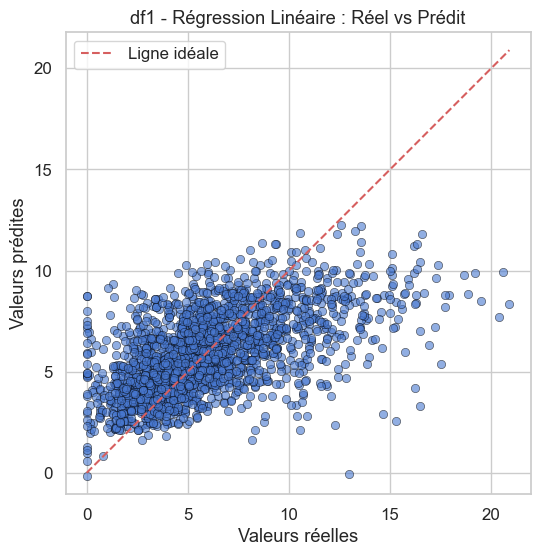


df1 - KNN
------------------------------
MAE  : 2.14
MSE  : 8.31
RMSE : 2.88
R²   : 0.33


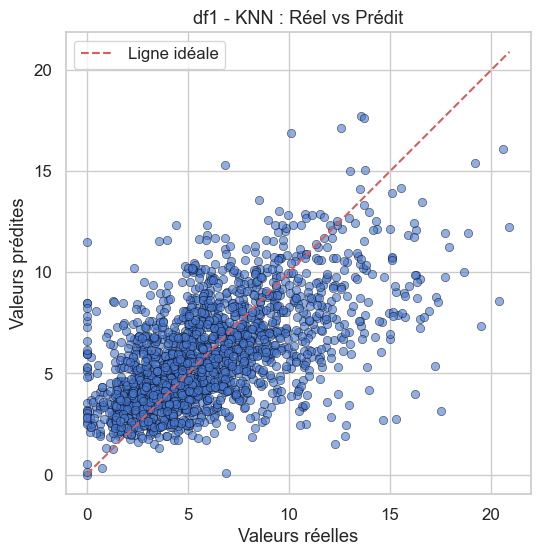


Le meilleur k (minimisant RMSE) est : 5


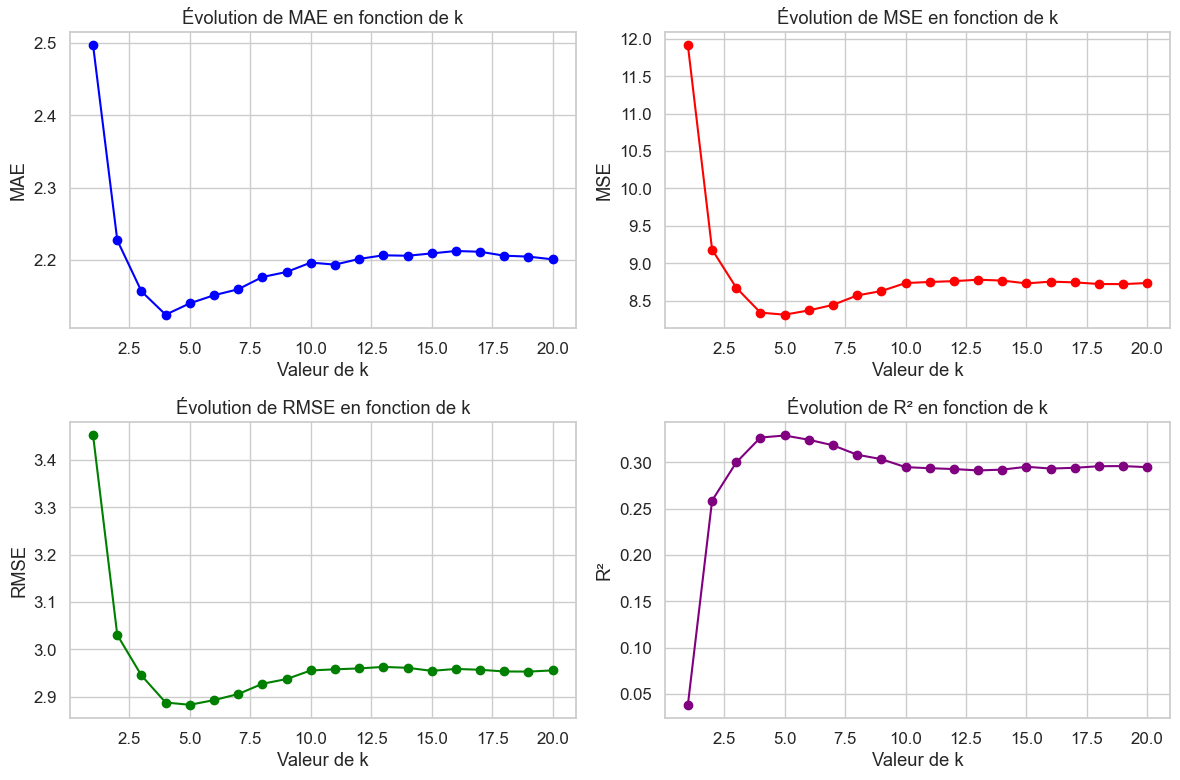


df1 - Random Forest
------------------------------
MAE  : 1.76
MSE  : 5.90
RMSE : 2.43
R²   : 0.52


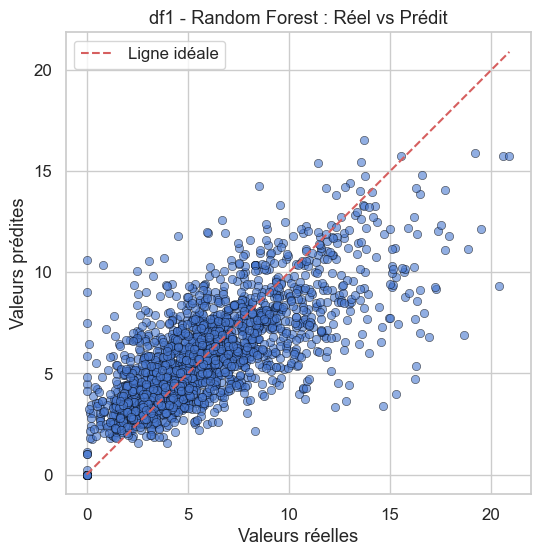


df2 - Régression Linéaire
------------------------------
MAE  : 1.92
MSE  : 7.11
RMSE : 2.67
R²   : 0.43


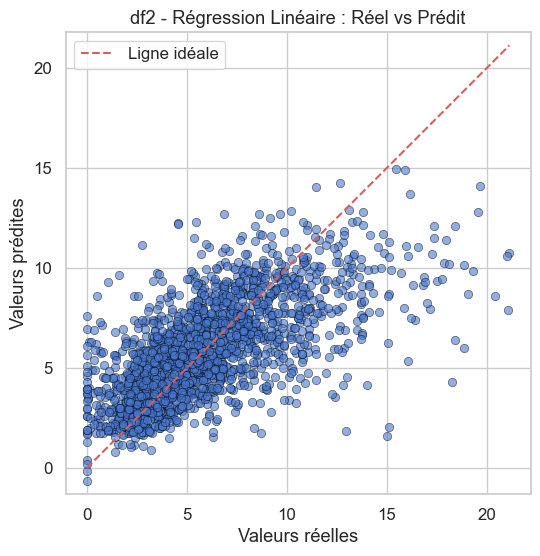


df2 - KNN
------------------------------
MAE  : 2.20
MSE  : 8.98
RMSE : 3.00
R²   : 0.29


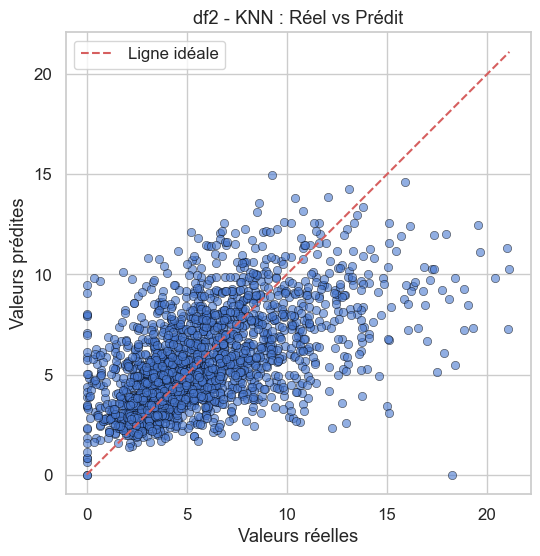


Le meilleur k (minimisant RMSE) est : 20


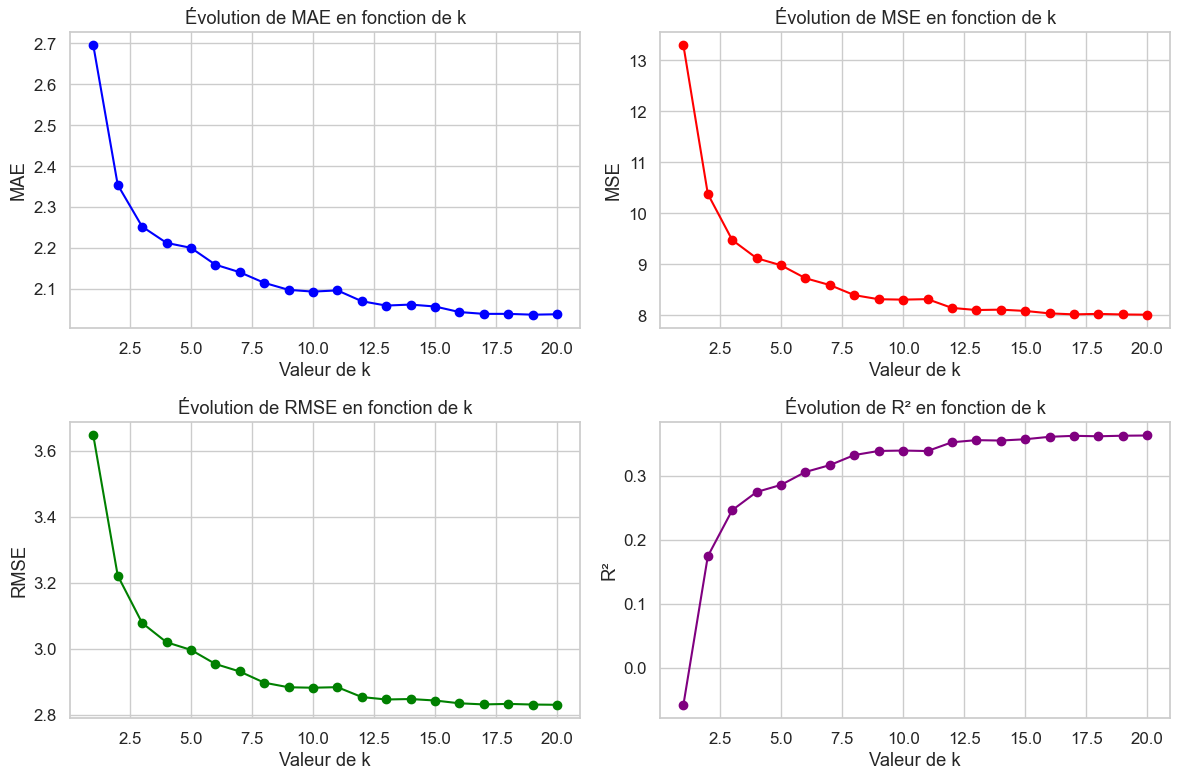


df2 - Random Forest
------------------------------
MAE  : 1.71
MSE  : 5.89
RMSE : 2.43
R²   : 0.53


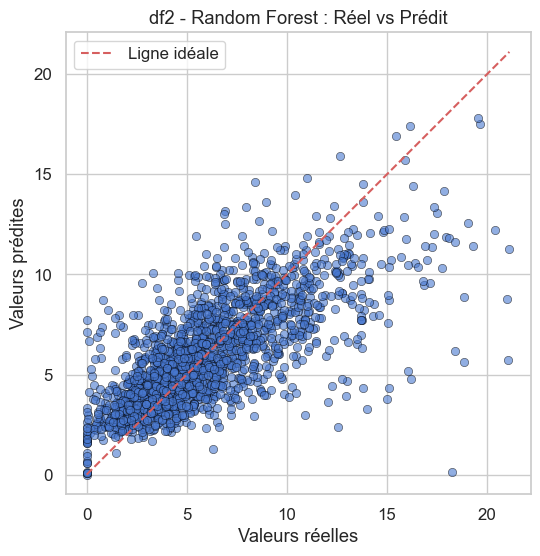


Résumé comparatif des performances :

                      Modèle       MAE       MSE      RMSE        R²
5        df2 - Random Forest  1.709591  5.894035  2.427763  0.531079
2        df1 - Random Forest  1.759934  5.904089  2.429833  0.523304
3  df2 - Régression Linéaire  1.924448  7.110296  2.666514  0.434315
1                  df1 - KNN  2.140258  8.311284  2.882930  0.328947
0  df1 - Régression Linéaire  2.136124  8.339533  2.887825  0.326667
4                  df2 - KNN  2.200287  8.981606  2.996933  0.285436


In [42]:
# Exécution des modèles pour deux ensembles de données
results1 = run_models(X1_train, y1_train, X1_holdout, y1_holdout, name_prefix="df1 - ")
results2 = run_models(X2_train, y2_train, X2_holdout, y2_holdout, name_prefix="df2 - ")

# Résumé des résultats
results_df = pd.DataFrame(results1 + results2, columns=["Modèle", "MAE", "MSE", "RMSE", "R²"])
print("\nRésumé comparatif des performances :\n")
print(results_df.sort_values(by="RMSE"))

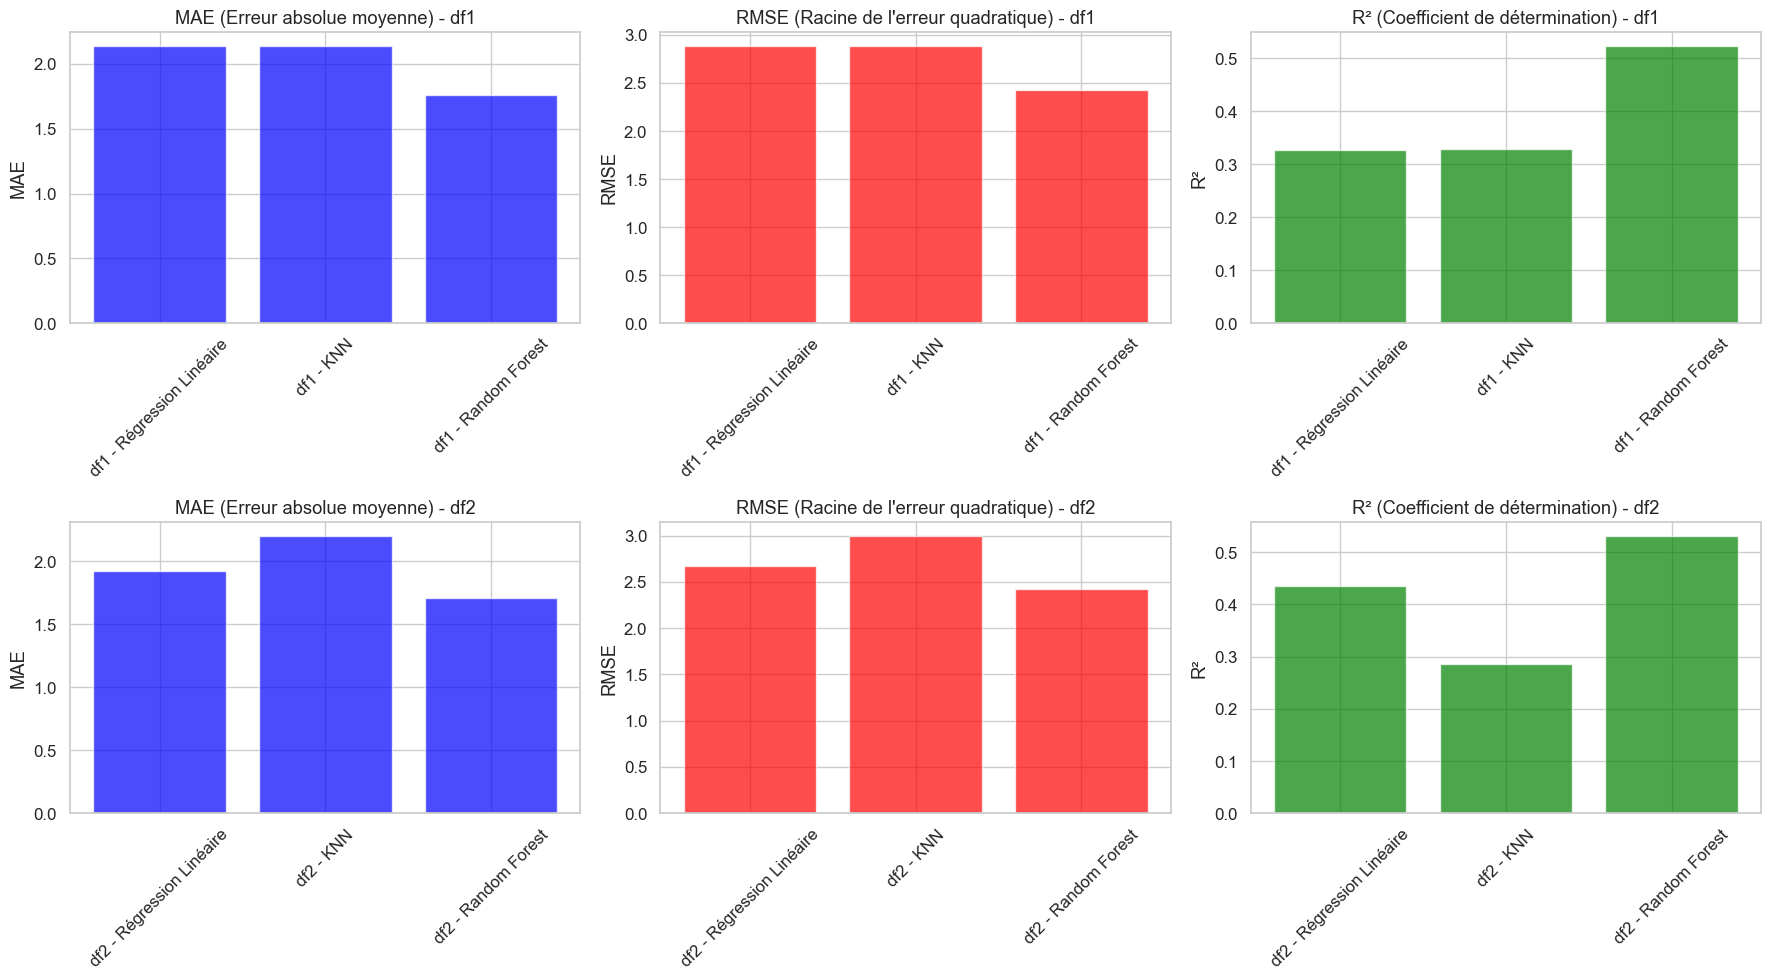

In [43]:
# Résultats pour df1
mae_df1 = results_df[results_df['Modèle'].str.contains('df1')]['MAE'].values
rmse_df1 = results_df[results_df['Modèle'].str.contains('df1')]['RMSE'].values
r2_df1 = results_df[results_df['Modèle'].str.contains('df1')]['R²'].values
models_df1 = results_df[results_df['Modèle'].str.contains('df1')]['Modèle'].values

# Résultats pour df2
mae_df2 = results_df[results_df['Modèle'].str.contains('df2')]['MAE'].values
rmse_df2 = results_df[results_df['Modèle'].str.contains('df2')]['RMSE'].values
r2_df2 = results_df[results_df['Modèle'].str.contains('df2')]['R²'].values
models_df2 = results_df[results_df['Modèle'].str.contains('df2')]['Modèle'].values

# Création de la figure avec 3 colonnes et 2 lignes pour mieux gérer l'affichage
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Graphique pour df1
axes[0, 0].bar(models_df1, mae_df1, color='blue', alpha=0.7)
axes[0, 0].set_title('MAE (Erreur absolue moyenne) - df1')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].set_xticklabels(models_df1, rotation=45)

axes[0, 1].bar(models_df1, rmse_df1, color='red', alpha=0.7)
axes[0, 1].set_title('RMSE (Racine de l\'erreur quadratique) - df1')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_xticklabels(models_df1, rotation=45)

axes[0, 2].bar(models_df1, r2_df1, color='green', alpha=0.7)
axes[0, 2].set_title('R² (Coefficient de détermination) - df1')
axes[0, 2].set_ylabel('R²')
axes[0, 2].set_xticklabels(models_df1, rotation=45)

# Graphique pour df2
axes[1, 0].bar(models_df2, mae_df2, color='blue', alpha=0.7)
axes[1, 0].set_title('MAE (Erreur absolue moyenne) - df2')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_xticklabels(models_df2, rotation=45)

axes[1, 1].bar(models_df2, rmse_df2, color='red', alpha=0.7)
axes[1, 1].set_title('RMSE (Racine de l\'erreur quadratique) - df2')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_xticklabels(models_df2, rotation=45)

axes[1, 2].bar(models_df2, r2_df2, color='green', alpha=0.7)
axes[1, 2].set_title('R² (Coefficient de détermination) - df2')
axes[1, 2].set_ylabel('R²')
axes[1, 2].set_xticklabels(models_df2, rotation=45)

# Optimisation de l'affichage
plt.tight_layout()
plt.show()

### Poids des variables

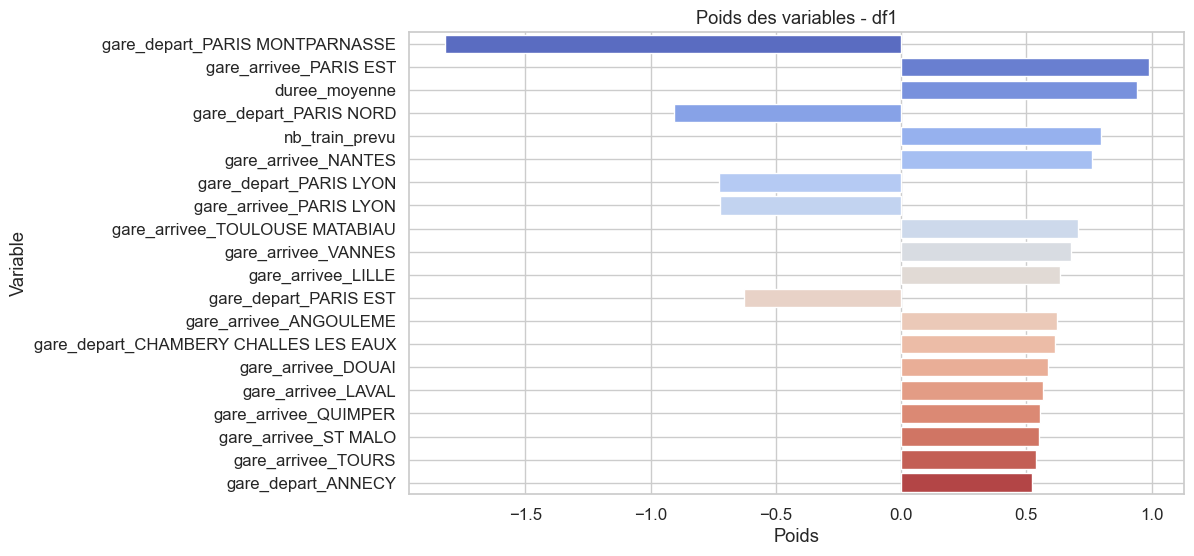

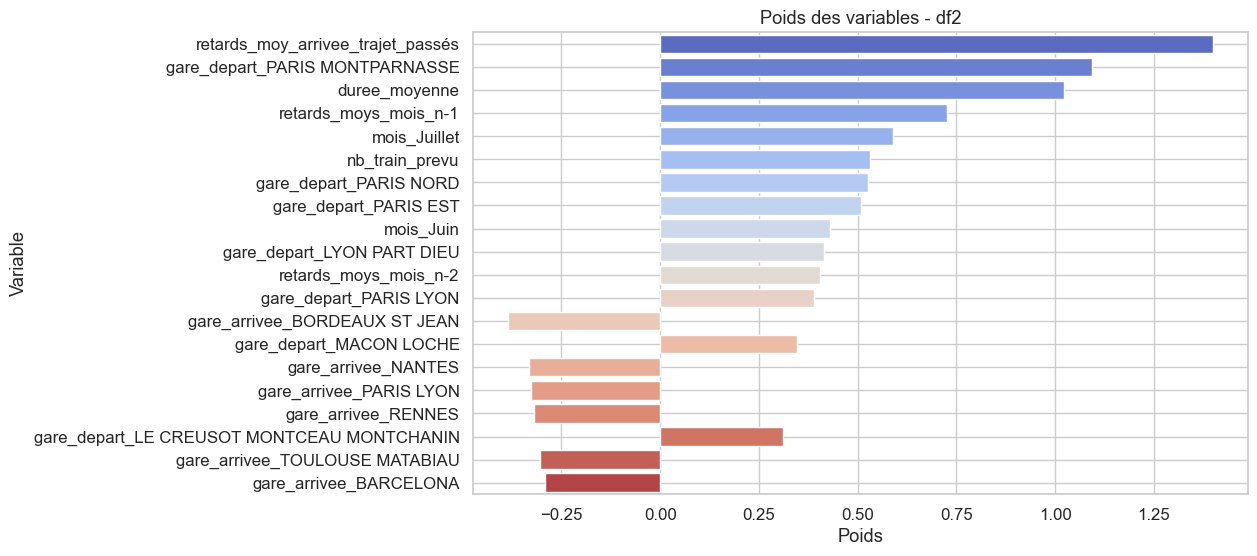

In [44]:
def plot_linear_weights(model, X_train, feature_names, title, top_n=20):
    coefs = model.coef_
    coef_df = pd.DataFrame({'Variable': feature_names, 'Poids': coefs})
    coef_df = coef_df.sort_values(by='Poids', key=abs, ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=coef_df, x='Poids', y='Variable', palette="coolwarm")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Pour df1
lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)
plot_linear_weights(lr1, X1_train, X1.columns, "Poids des variables - df1")

# Pour df2
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
plot_linear_weights(lr2, X2_train, X2.columns, "Poids des variables - df2")

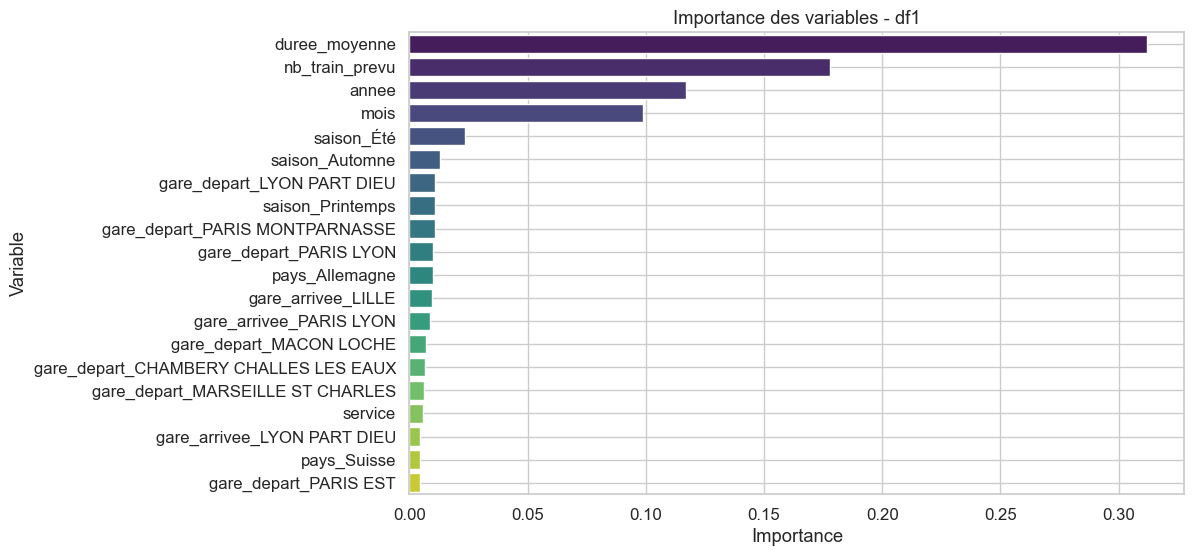

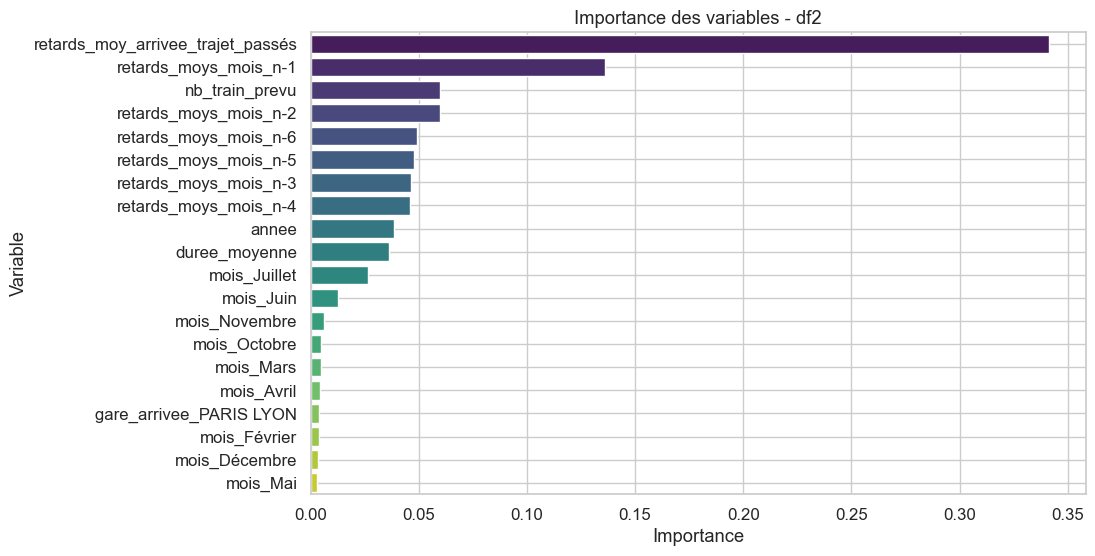

In [45]:
def plot_feature_importances(model, feature_names, title):
    importances = model.feature_importances_
    imp_df = pd.DataFrame({'Variable': feature_names, 'Importance': importances})
    imp_df = imp_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=imp_df.head(20), x='Importance', y='Variable', palette='viridis')
    plt.title(title)
    plt.grid(True)
    plt.show()
    
rf1 = RandomForestRegressor(random_state=42)
rf1.fit(X1_train, y1_train)
plot_feature_importances(rf1, X1.columns, "Importance des variables - df1")

rf2 = RandomForestRegressor(random_state=42)
rf2.fit(X2_train, y2_train)
plot_feature_importances(rf2, X2.columns, "Importance des variables - df2")

### Méthode par classification

In [46]:
# Classification : Création de la cible catégorielle pour les retards
# 0 = pas de retard (<5 min), 1 = léger retard (5-10 min), 2 = fort retard (>10 min)
def categorize_delay(x):
    if x < 5:
        return 0
    elif x <= 10:
        return 1
    else:
        return 2

# Appliquer la catégorisation sur le dataframe df2
df2_classif = df2.copy()
df2_classif["retard_cat"] = df2_classif["retard_moyen_tous_trains_arrivee"].apply(categorize_delay)

# 2. Séparation des données en features (X) et cible (y), et séparation en ensembles d'entraînement et de test
X2c = df2_classif.drop(columns=["retard_moyen_tous_trains_arrivee", "retard_cat"])
y2c = df2_classif["retard_cat"]

# Split des données en train et holdout
X2c_train, X2c_holdout, y2c_train, y2c_holdout = train_test_split(X2c, y2c, test_size=0.2, stratify=y2c)

# Standardisation des données
scaler2c = StandardScaler()
X2c_train = scaler2c.fit_transform(X2c_train)
X2c_holdout = scaler2c.transform(X2c_holdout)

# Convertir les données d'entraînement standardisées en DataFrame
X2c_train = pd.DataFrame(X2c_train, columns=X2c.columns)

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.73      0.80      0.77       954
           1       0.59      0.61      0.60       791
           2       0.55      0.31      0.39       253

    accuracy                           0.66      1998
   macro avg       0.62      0.57      0.59      1998
weighted avg       0.65      0.66      0.65      1998

Accuracy of Multinomial Regression is :  66.31631631631632


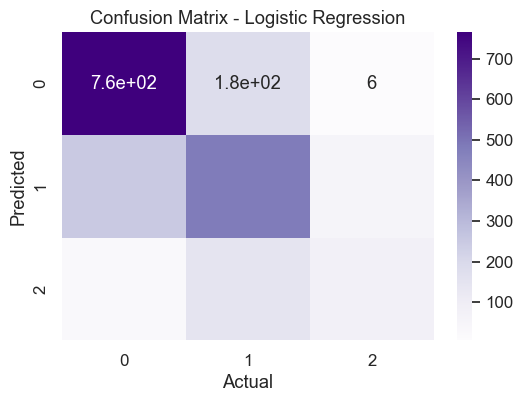

In [47]:
# Modèle de régression multinomiale
logreg_model = LogisticRegression(multi_class="multinomial", max_iter=1000)
logreg_model.fit(X2c_train, y2c_train)
logreg_pred = logreg_model.predict(X2c_holdout)

# Calcul des métriques et affichage du rapport de classification
print("Classification Report - Logistic Regression:")
print(classification_report(y2c_holdout, logreg_pred))
print("Accuracy of Multinomial Regression is : ", accuracy_score(y2c_holdout, logreg_pred) * 100)

# Matrice de confusion
confusion_matrix_logreg = confusion_matrix(y2c_holdout, logreg_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_logreg, annot=True, cmap="Purples")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

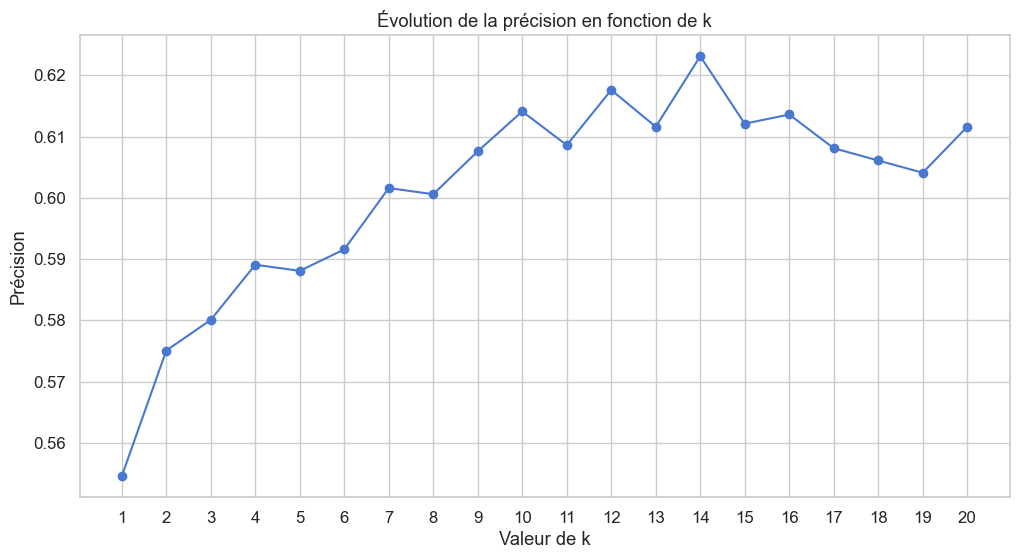

Classification Report - KNN:
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       954
           1       0.54      0.55      0.54       791
           2       0.55      0.19      0.29       253

    accuracy                           0.61      1998
   macro avg       0.59      0.51      0.52      1998
weighted avg       0.60      0.61      0.59      1998

Accuracy of KNN is :  61.16116116116116


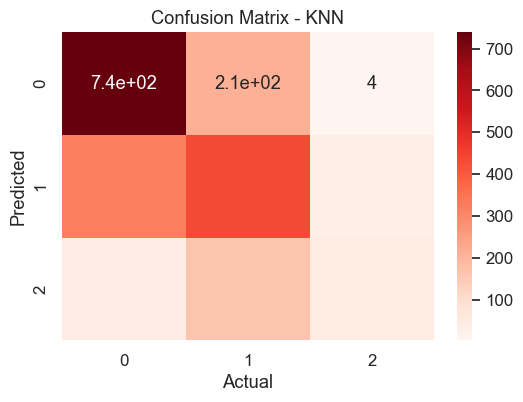

In [48]:
# Modèle K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier()
knn_model.fit(X2c_train, y2c_train)
knn_pred = knn_model.predict(X2c_holdout)

# Tracer l'évolution de la précision en fonction de k
k_values = list(range(1, 21))
accuracies = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X2c_train, y2c_train)
    knn_pred = knn_model.predict(X2c_holdout)
    accuracies.append(accuracy_score(y2c_holdout, knn_pred))

plt.plot(k_values, accuracies, marker='o')
plt.title('Évolution de la précision en fonction de k')
plt.xlabel('Valeur de k')
plt.ylabel('Précision')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Affichage du rapport de classification pour KNN
print("Classification Report - KNN:")
print(classification_report(y2c_holdout, knn_pred))
print("Accuracy of KNN is : ", accuracy_score(y2c_holdout, knn_pred) * 100)

# Matrice de confusion pour KNN
confusion_matrix_knn = confusion_matrix(y2c_holdout, knn_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_knn, annot=True, cmap="Reds")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix - KNN")
plt.show()

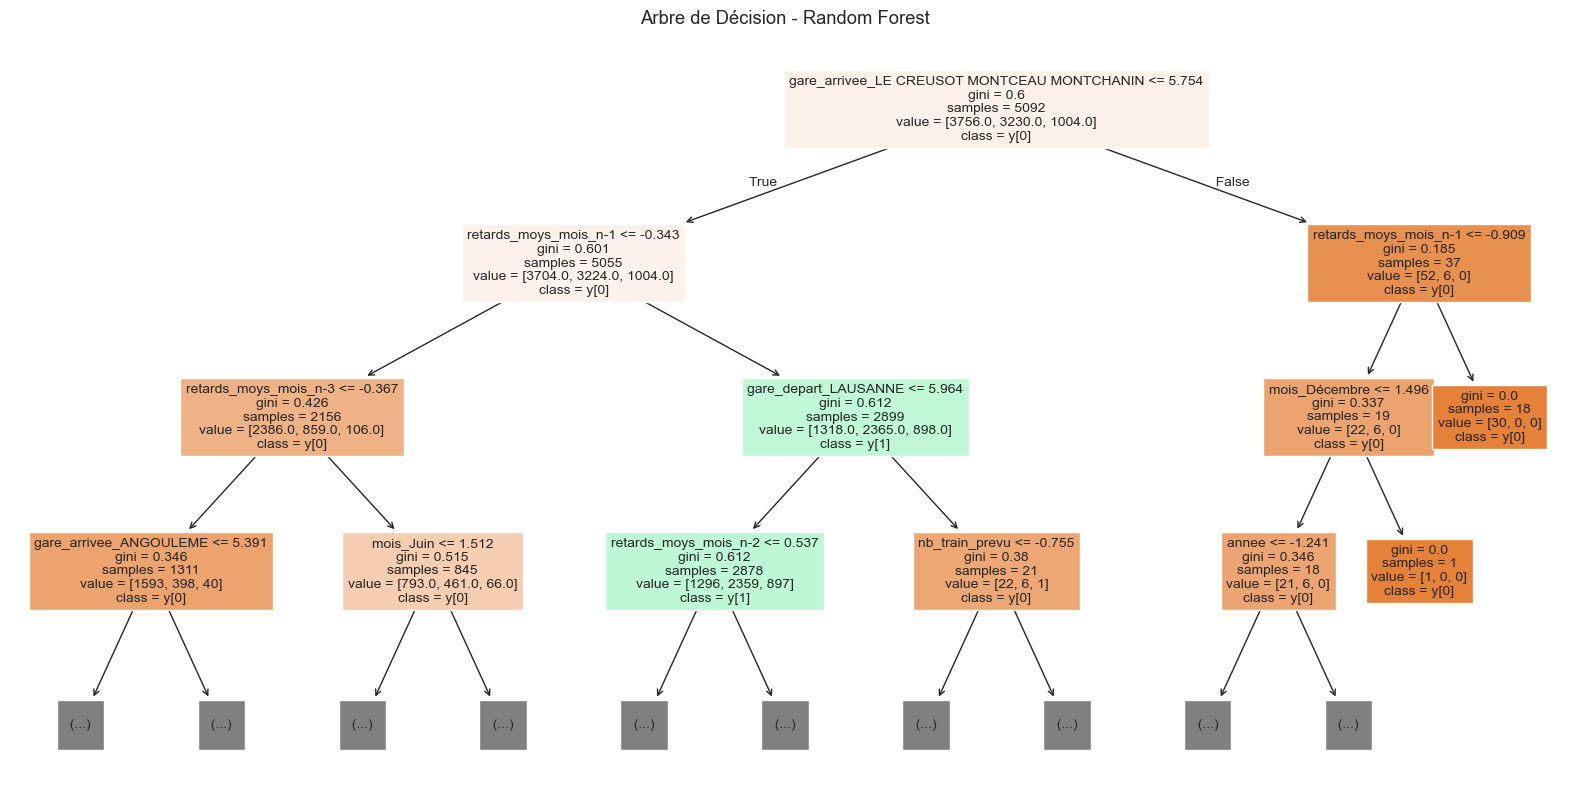

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       954
           1       0.64      0.66      0.65       791
           2       0.68      0.37      0.48       253

    accuracy                           0.71      1998
   macro avg       0.69      0.62      0.64      1998
weighted avg       0.70      0.71      0.70      1998

Accuracy of Random Forest is :  70.87087087087087


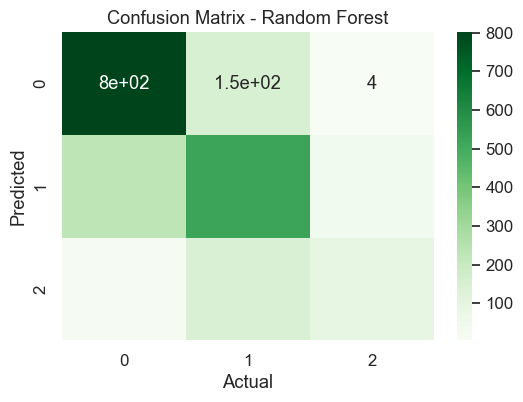

In [49]:
# Modèle Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X2c_train, y2c_train)
rf_pred = rf_model.predict(X2c_holdout)

# Extraire un arbre de la forêt et afficher sa structure
tree_from_forest = rf_model.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(tree_from_forest, filled=True, feature_names=X2c_train.columns, class_names=True, fontsize=10, max_depth=3)
plt.title("Arbre de Décision - Random Forest")
plt.show()

# Calcul des métriques et affichage du rapport de classification pour Random Forest
print("Classification Report - Random Forest:")
print(classification_report(y2c_holdout, rf_pred))
print("Accuracy of Random Forest is : ", accuracy_score(y2c_holdout, rf_pred) * 100)

# Matrice de confusion pour Random Forest
confusion_matrix_rf = confusion_matrix(y2c_holdout, rf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_rf, annot=True, cmap="Greens")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [50]:
# Comparaison des modèles
models = ['KNN', 'Random Forest', 'Multinomial Regression']
accuracies = [accuracy_score(y2c_holdout, knn_pred), accuracy_score(y2c_holdout, rf_pred), accuracy_score(y2c_holdout, logreg_pred)]
precisions = [precision_score(y2c_holdout, knn_pred, average='macro'), precision_score(y2c_holdout, rf_pred, average='macro'), precision_score(y2c_holdout, logreg_pred, average='macro')]
recalls = [recall_score(y2c_holdout, knn_pred, average='macro'), recall_score(y2c_holdout, rf_pred, average='macro'), recall_score(y2c_holdout, logreg_pred, average='macro')]
f1_scores = [f1_score(y2c_holdout, knn_pred, average='macro'), f1_score(y2c_holdout, rf_pred, average='macro'), f1_score(y2c_holdout, logreg_pred, average='macro')]
balanced_accuracies = [balanced_accuracy_score(y2c_holdout, knn_pred), balanced_accuracy_score(y2c_holdout, rf_pred), balanced_accuracy_score(y2c_holdout, logreg_pred)]

# Création d'un dataframe pour la comparaison des modèles
model_comparison = pd.DataFrame({
    'Model': models, 
    'Accuracy': accuracies, 
    'Precision': precisions,
    'Recall': recalls, 
    'F1 Score': f1_scores,
    'Balanced Accuracy': balanced_accuracies
})

In [51]:
# Affichage des résultats sous forme de tableau
table = tabulate(model_comparison, headers='keys', tablefmt='fancy_grid', showindex=False)
print(table)

╒════════════════════════╤════════════╤═════════════╤══════════╤════════════╤═════════════════════╕
│ Model                  │   Accuracy │   Precision │   Recall │   F1 Score │   Balanced Accuracy │
╞════════════════════════╪════════════╪═════════════╪══════════╪════════════╪═════════════════════╡
│ KNN                    │   0.611612 │    0.586282 │ 0.505661 │   0.516207 │            0.505661 │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼─────────────────────┤
│ Random Forest          │   0.708709 │    0.69433  │ 0.623275 │   0.64341  │            0.623275 │
├────────────────────────┼────────────┼─────────────┼──────────┼────────────┼─────────────────────┤
│ Multinomial Regression │   0.663163 │    0.624162 │ 0.573181 │   0.587157 │            0.573181 │
╘════════════════════════╧════════════╧═════════════╧══════════╧════════════╧═════════════════════╛


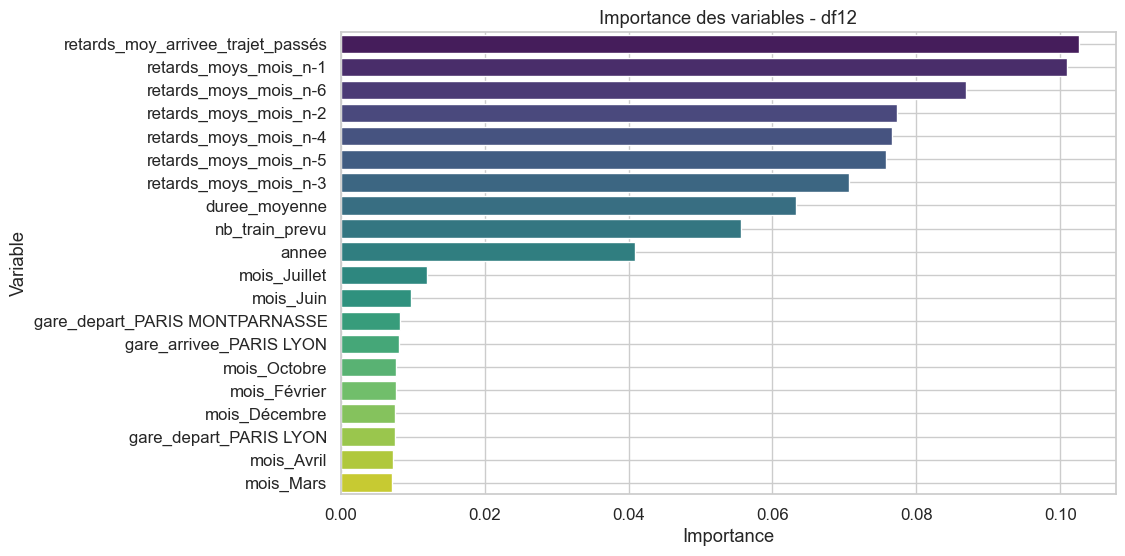

In [52]:
# Affichage des importances des caractéristiques pour le modèle Random Forest
plot_feature_importances(rf_model, X2c.columns, "Importance des variables - df12")

### Visualisation des résultats des modèles

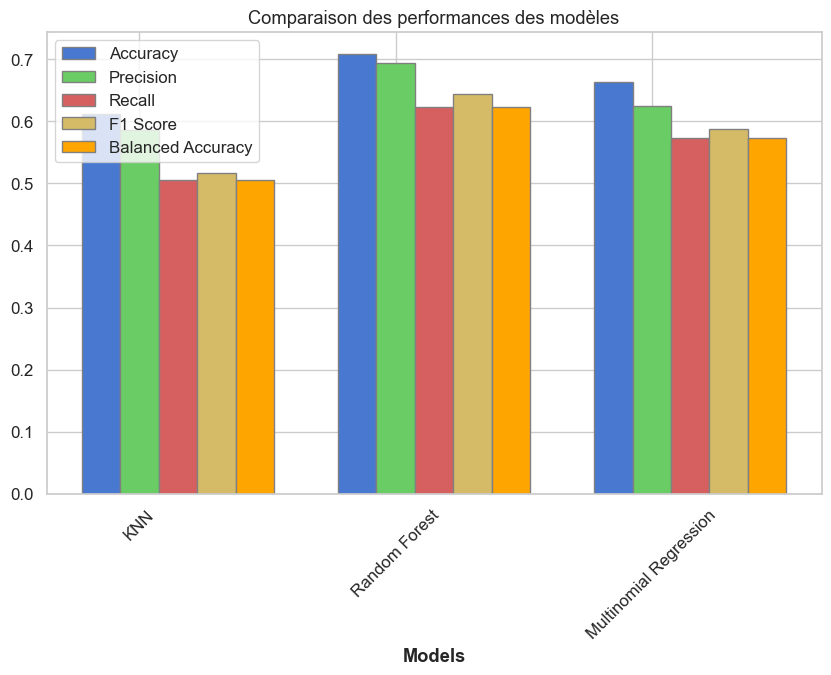

In [53]:
# Comparaison des scores des modèles
plt.figure(figsize=(10, 6))
barWidth = 0.15
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.bar(r1, accuracies, color='b', width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r2, precisions, color='g', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r3, recalls, color='r', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r4, f1_scores, color='y', width=barWidth, edgecolor='grey', label='F1 Score')
plt.bar(r5, balanced_accuracies, color='orange', width=barWidth, edgecolor='grey', label='Balanced Accuracy')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models, rotation=45)
plt.legend()
plt.title('Comparaison des performances des modèles')
plt.show()

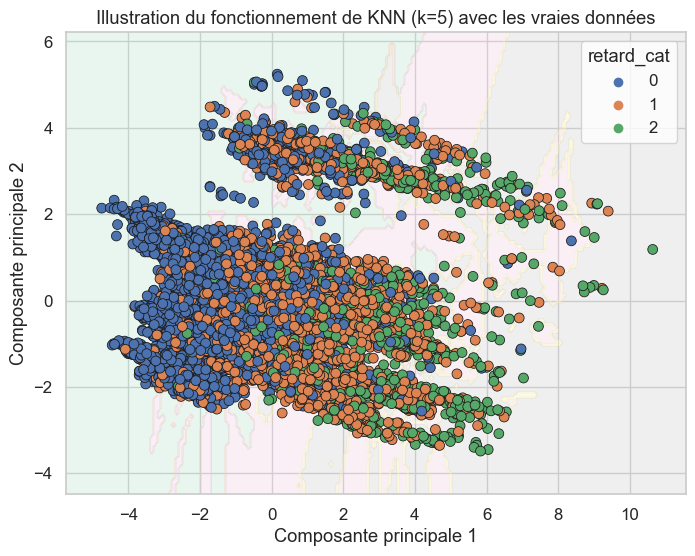

In [54]:
# Visualisation du fonctionnement de KNN avec les vraies données
from sklearn.decomposition import PCA

# Réduire les données à 2 dimensions pour affichage
pca = PCA(n_components=2)
X2c_train_2D = pca.fit_transform(X2c_train)

# Créer un modèle KNN (par exemple k=5)
knn_visu = KNeighborsClassifier(n_neighbors=5)
knn_visu.fit(X2c_train_2D, y2c_train)

# Créer une grille pour visualiser les frontières
x_min, x_max = X2c_train_2D[:, 0].min() - 1, X2c_train_2D[:, 0].max() + 1
y_min, y_max = X2c_train_2D[:, 1].min() - 1, X2c_train_2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = knn_visu.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracer
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel2')
sns.scatterplot(x=X2c_train_2D[:, 0], y=X2c_train_2D[:, 1], hue=y2c_train, palette='deep', s=50, edgecolor='k')
plt.title("Illustration du fonctionnement de KNN (k=5) avec les vraies données")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()